# Clustering

The goal of this notebook is to perform a customer segmentation based on the olist dataset.

In order to define the optimal number of clusters the following algorithms will be used:

1. K-Means
2. Hierarchical Clustering
3. DBSCAN

# Imports

## Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score, jaccard_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('whitegrid', {'grid.linewidth': .05, 'grid.color': '.85'})

## Data

We will use the RFM dataset from the previous notebook.

In [92]:
df_rfm = pd.read_csv('data/cleaned/df_rfm.csv')
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,Satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.9000,5.0000
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.1900,4.0000
2,0000f46a3911fa3c0805444483337064,541,1,86.2200,3.0000
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.6200,4.0000
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.8900,5.0000


In [93]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95419 entries, 0 to 95418
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  95419 non-null  object 
 1   Recency             95419 non-null  int64  
 2   Frequency           95419 non-null  int64  
 3   Monetary            95419 non-null  float64
 4   Satisfaction        95419 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 3.6+ MB


In [94]:
rfm_features = ['Recency', 'Frequency', 'Monetary']
rfms_features = ['Recency', 'Frequency', 'Monetary', 'Satisfaction']

In [95]:
df_rfm = df_rfm[rfms_features]

# KMeans

We start with KMeans because it is considered to be a general purpose algorithm that scales well to a large number of samples, produces even cluster size and is suitable for a reasonable number of clusters.

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. 

Here is the process that will be used with the KMeans:

1. Scale the data with StandardScaler.
2. Train the KMeans with up to 10 clusters and calculate the inertia and silhouette score for each cluster parameter.
3. Pick 2 numbers of clusters using the elbow method and silhouette score.
4. Train KMeans for the 2 cluster parameters and analyze the segments produced.
5. Choose the segmentation that looks the most consistent from the domain point of view.

Do the whole procedure for the RFM dataset with only Recency/Frequency/Monetary features and repeat for the RFM dataset + Satisfaction feature.

## RFM

Scale the data

In [96]:
scaler_rfm = StandardScaler()
X_rfm_scaled = scaler_rfm.fit_transform(df_rfm[rfm_features])
X_rfm_scaled

array([[-0.83312584, -0.16104597, -0.10585274],
       [-0.81353754, -0.16104597, -0.60821607],
       [ 1.94841326, -0.16104597, -0.34969888],
       ...,
       [ 2.15082573, -0.16104597, -0.23478289],
       [-0.78089037, -0.16104597, -0.14180779],
       [ 1.60235323, -0.16104597, -0.41390119]])

### Choosing number of clusters

In [97]:
def get_clusters(X, max_cluster=9):
    n_cluster = range(2, max_cluster, 1)
    inertia = []
    silhouette = []

    for i in n_cluster:
        model = KMeans(n_clusters=i, n_init=10, random_state=0)
        y_labels = model.fit_predict(X)
        inertia.append(model.inertia_)

        score = silhouette_score(X, y_labels)
        silhouette.append(score)
        print(f'cluster {i}: {score} score')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(n_cluster, inertia, marker="o")
    ax1.set_xlabel("Number of Segments")
    ax1.set_ylabel("Inertia Value")

    ax2.plot(n_cluster, silhouette, marker="o", c="green")
    ax2.set_xlabel("Number of Segments")
    ax2.set_ylabel("Silhouette score")

    fig.tight_layout()

cluster 2: 0.737225440089995 score
cluster 3: 0.45599245015848194 score
cluster 4: 0.4884918667304684 score
cluster 5: 0.41798111506122343 score
cluster 6: 0.43627961148418726 score
cluster 7: 0.4385894060399689 score
cluster 8: 0.44546176356186423 score
cluster 9: 0.39021191108539244 score
cluster 10: 0.38327056193216574 score


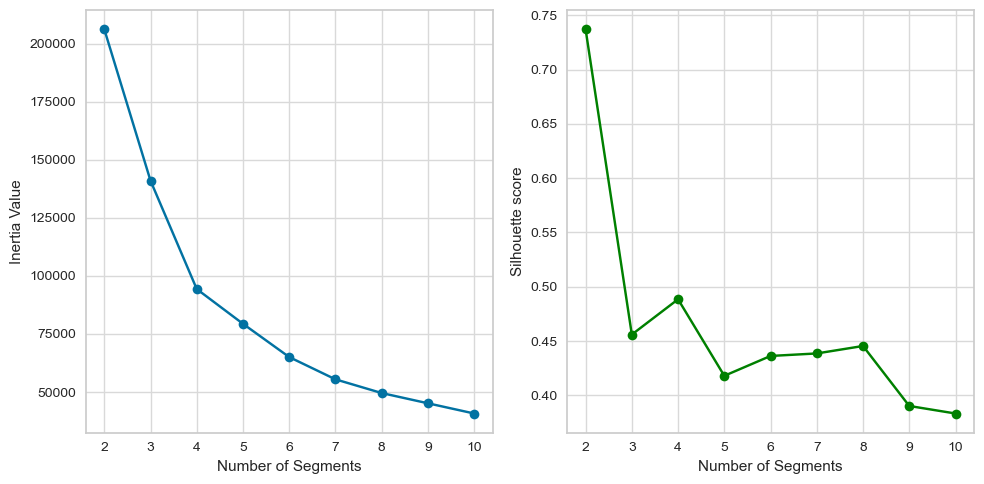

In [98]:
get_clusters(X_rfm_scaled, max_cluster=11)

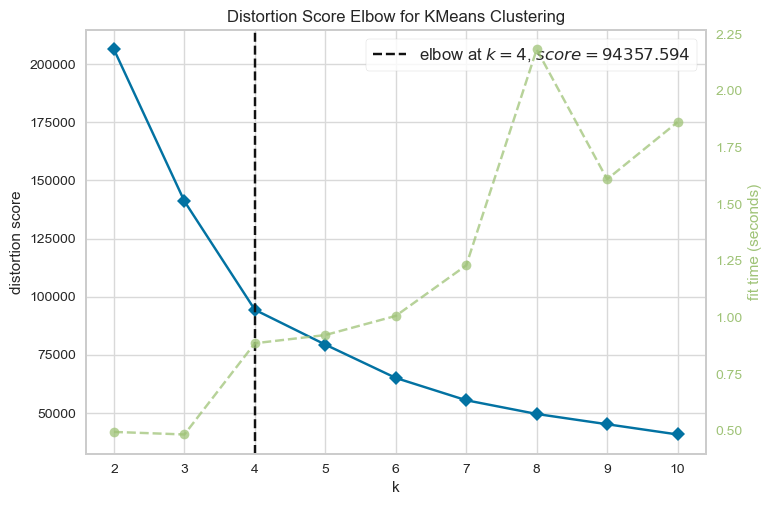

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init=10, random_state=0),
                 k=(2, 11))

In [99]:
kelbow_visualizer(KMeans(random_state=0, n_init=10), X_rfm_scaled, k=(2, 11))

From the distortion plot and silhouette score, 4 segments look like the best fit, but we observe a quite good silhouette score for 3 segments.

### 4 clusters

Train the model for 4 clusters

In [100]:
time_before = time.time()

model_rfm4 = KMeans(n_clusters=4, random_state=0, n_init=10)
y_rfm4 = model_rfm4.fit_predict(X_rfm_scaled)
score_rfm4 = silhouette_score(X_rfm_scaled, y_rfm4)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

print(score_rfm4)

df_rfm["Segment_RFM_4"] = y_rfm4
df_rfm.head(10)

execution time: 62.135 seconds
0.4884918667304684


,Recency,Frequency,Monetary,Satisfaction,Segment_RFM_4
0,115,1,141.9000,5.0000,2
1,118,1,27.1900,4.0000,2
2,541,1,86.2200,3.0000,0
3,325,1,43.6200,4.0000,0
4,292,1,196.8900,5.0000,0
5,150,1,166.9800,4.0000,2
6,135,1,35.3800,4.0000,2
7,186,1,419.1800,1.0000,2
8,547,1,150.1200,4.0000,0
9,174,1,129.7600,1.0000,2


Group the segments to have a better idea for what they stand for

In [101]:
df_rfm[rfm_features].describe()

,Recency,Frequency,Monetary
count,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705
std,153.1534,0.2112,228.3419
min,0.0000,1.0000,9.5900
25%,118.0000,1.0000,63.1000
50%,223.0000,1.0000,107.9500
75%,352.0000,1.0000,183.2700
max,728.0000,16.0000,13664.0800


In [102]:
df_rfm[rfm_features + ['Segment_RFM_4']].groupby("Segment_RFM_4").mean()

,Recency,Frequency,Monetary
Segment_RFM_4,,,
0,392.7301,1.0000,134.3247
1,244.1444,1.0138,1173.0243
2,132.4977,1.0000,134.7169
3,225.2072,2.1149,289.6197


At this stage we can roughly decide on the following groups: <br/>
- segment 0: high recency, avg frequency, avg monetary
- segment 1: avg recency, avg frequency, the highest monetary
- segment 2: low recency, avg frequency, avg monetary
- segment 3: avg recency, high frequency, slightly more than avg monetary

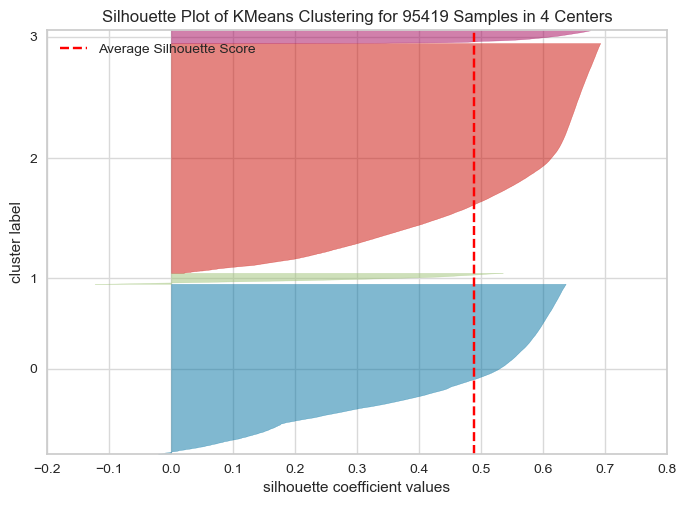

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 95419 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, n_init=10, random_state=0))

In [103]:
silhouette_visualizer(model_rfm4, X_rfm_scaled, colors='yellowbrick')

Clusters 0 and 2 are the biggest, 3 and 1 contain less points. From the silhouette plot above we observe that all points except for the cluster 1 have been well categorized, cluster 1 has many points with a weak silhouette value that can go below 0 for some of them.

In [104]:
df_rfm['Segment_RFM_4'].value_counts()

2    51787
0    38285
3     2881
1     2466
Name: Segment_RFM_4, dtype: int64

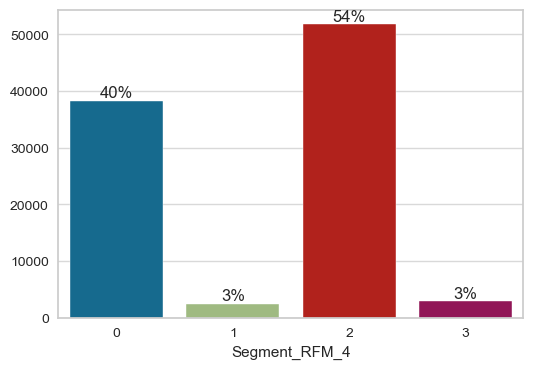

In [105]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm['Segment_RFM_4'], ax=ax)

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f}%'.format(x/df_rfm.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

### 3 clusters

Let's train the KMeans with 3 clusters and see if we obtain a better segmentation

In [106]:
time_before = time.time()

model_rfm3 = KMeans(n_clusters=3, random_state=0, n_init=10)
y_rfm3 = model_rfm3.fit_predict(X_rfm_scaled)
score_rfm3 = silhouette_score(X_rfm_scaled, y_rfm3)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

print(score_rfm3)

df_rfm["Segment_RFM_3"] = y_rfm3
df_rfm.head(10)

execution time: 62.5148 seconds
0.45599245015848194


,Recency,Frequency,Monetary,Satisfaction,Segment_RFM_4,Segment_RFM_3
0,115,1,141.9000,5.0000,2,2
1,118,1,27.1900,4.0000,2,2
2,541,1,86.2200,3.0000,0,0
3,325,1,43.6200,4.0000,0,0
4,292,1,196.8900,5.0000,0,0
5,150,1,166.9800,4.0000,2,2
6,135,1,35.3800,4.0000,2,2
7,186,1,419.1800,1.0000,2,2
8,547,1,150.1200,4.0000,0,0
9,174,1,129.7600,1.0000,2,2


In [107]:
df_rfm[rfm_features].describe()

,Recency,Frequency,Monetary
count,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705
std,153.1534,0.2112,228.3419
min,0.0000,1.0000,9.5900
25%,118.0000,1.0000,63.1000
50%,223.0000,1.0000,107.9500
75%,352.0000,1.0000,183.2700
max,728.0000,16.0000,13664.0800


In [108]:
df_rfm[rfm_features + ['Segment_RFM_3']].groupby("Segment_RFM_3").mean()

,Recency,Frequency,Monetary
Segment_RFM_3,,,
0,392.5419,1.0000,162.0295
1,225.2246,2.1113,329.2386
2,132.3801,1.0000,160.0936


We can roughly consider the following groups of customers: <br/>
- segment 0: high recency, avg frequency, avg monetary
- segment 1: avg recency, best frequency, the highest monetary
- segment 2: the most recent, avg frequency, avg monetary

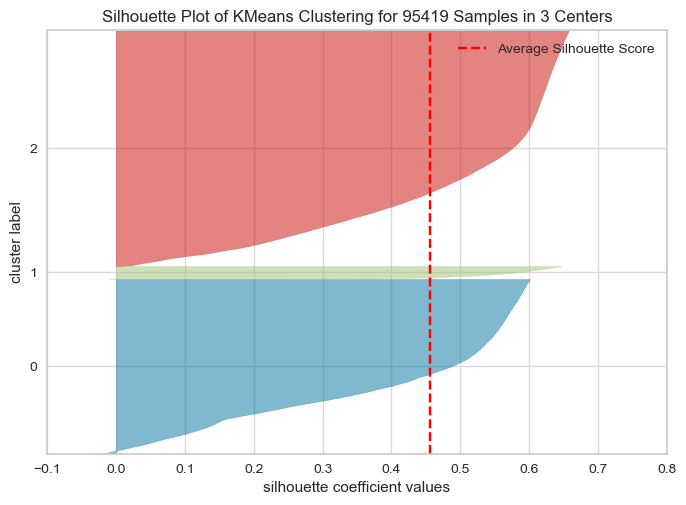

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 95419 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=0))

In [109]:
silhouette_visualizer(model_rfm3, X_rfm_scaled, colors='yellowbrick')

In [110]:
df_rfm['Segment_RFM_3'].value_counts()

2    53117
0    39381
1     2921
Name: Segment_RFM_3, dtype: int64

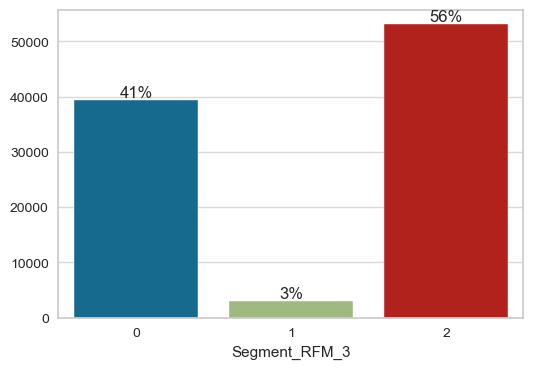

In [111]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm['Segment_RFM_3'], ax=ax)

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f}%'.format(x/df_rfm.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

With the 3 group segmentation we observe the same 2 biggest segments as in 4 groups segmentation with the same caracteristics, however, we lost the group of clients with the best monetary value. From the domain point of view, it would be interesting to have a separate segment of customers who spend the most. For this reason, 4 cluster segmentation brings more value.

### 4 segments analysis

To have a better understanding of what each cluster represents, we'll do a more detailed analysis of the RFM features for each cluster

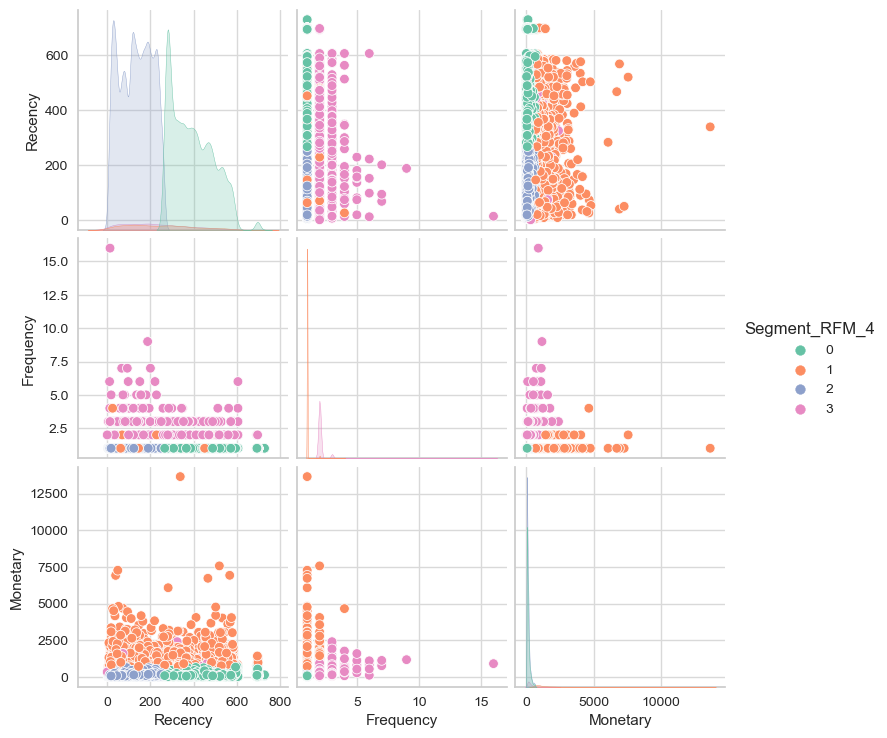

In [112]:
sns.pairplot(df_rfm[rfm_features + ['Segment_RFM_4']],
             hue="Segment_RFM_4", palette="Set2")

<u>Interesting insights:</u>
1. The segmentation by `Recency` is very well represented in the very first graph, we can clearly distinguish segment 0 and 2 that represent the most and the least recent clients.
2. No particular relation on `Monetary` or `Frequency` with the `Recency`.
3. The `Monetary` graph should use the log scaling to have a better idea of the representation of different groups, nevertheless we can observe the separation of the group 1 (orange - high spenders) and all the others along the `Monetary` axis.
4. Same for the `Frequency`, a log scaled graph would be more clear but still we can observe the group 3 (rose - most frequent) which is different from all the others.
5. We can see a slight relation between `Frequency` and `Monetary` for the Clusters 1 (orange - high spenders) and 3 (rose, most frequent)

In [326]:
segments = df_rfm['Segment_RFM_4'].sort_values().unique()
segments

array(['0', '1', '2', '3'], dtype=object)

**Distribution**


Let's compare the feature distribution inside each cluster with the average values

In [327]:
df_rfm[rfm_features].describe()

,Recency,Frequency,Monetary
count,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705
std,153.1534,0.2112,228.3419
min,0.0000,1.0000,9.5900
25%,118.0000,1.0000,63.1000
50%,223.0000,1.0000,107.9500
75%,352.0000,1.0000,183.2700
max,728.0000,16.0000,13664.0800


In the distribution plots below the red line stands for the global median for the given feature

------------------
Segment 0
------------------

(38285, 9)
Recency
------------------
count   38285.0000
mean      392.7301
std        96.5084
min       263.0000
25%       304.0000
50%       380.0000
75%       467.0000
max       728.0000
Name: Recency, dtype: float64


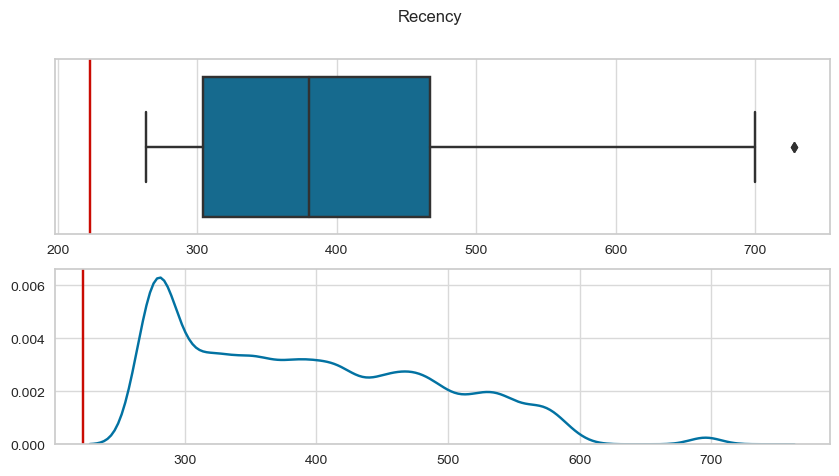

Frequency
------------------
count   38285.0000
mean        1.0000
std         0.0000
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: Frequency, dtype: float64


/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/2338447943.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=feature_subset, ax=ax2)


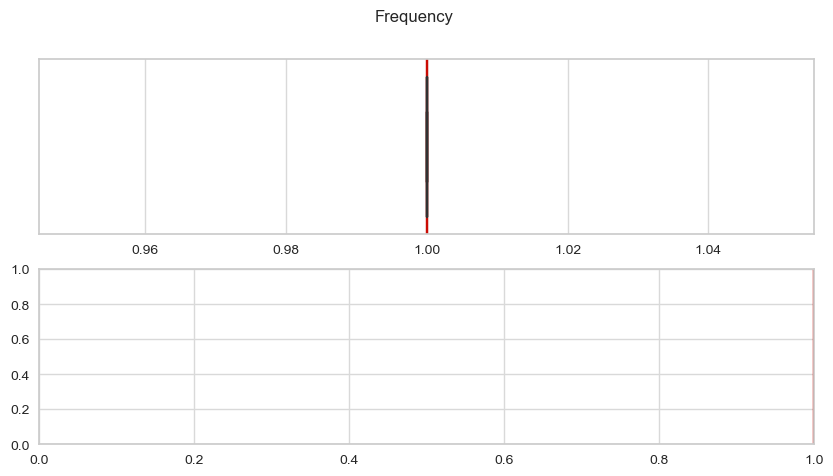

Monetary
------------------
count   38285.0000
mean      134.3247
std       109.2506
min        10.0700
25%        61.0500
50%       101.7300
75%       167.5100
max       740.6200
Name: Monetary, dtype: float64


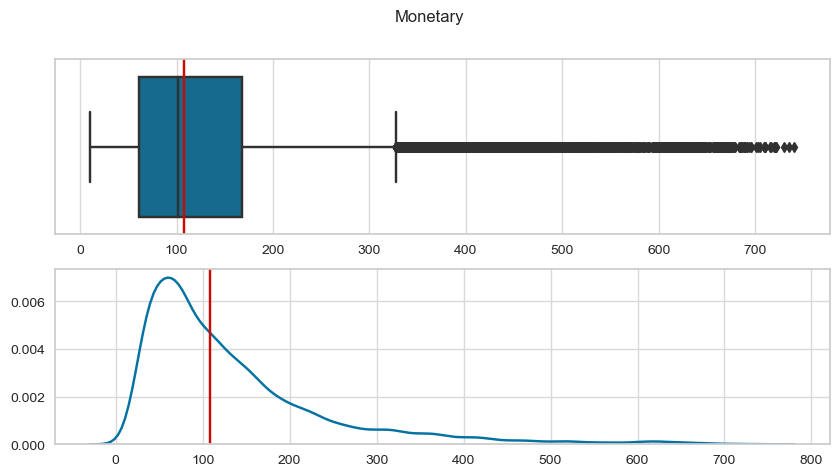

------------------
Segment 1
------------------

(2466, 9)
Recency
------------------
count   2466.0000
mean     244.1444
std      152.3142
min        5.0000
25%      117.0000
50%      229.0000
75%      353.0000
max      698.0000
Name: Recency, dtype: float64


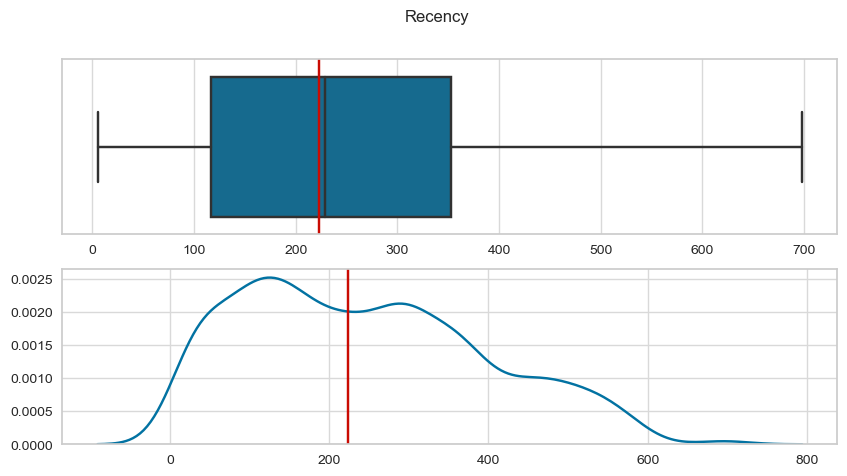

Frequency
------------------
count   2466.0000
mean       1.0138
std        0.1266
min        1.0000
25%        1.0000
50%        1.0000
75%        1.0000
max        4.0000
Name: Frequency, dtype: float64


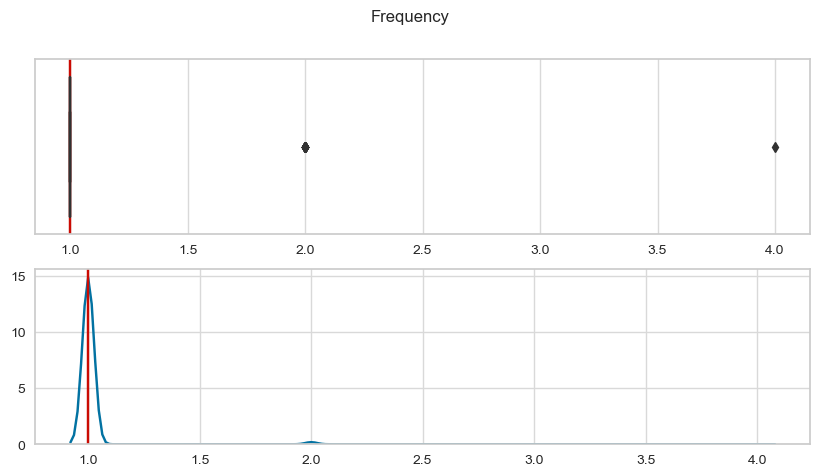

Monetary
------------------
count    2466.0000
mean     1173.0243
std       679.5133
min       639.2800
25%       782.2800
50%       948.0350
75%      1338.4100
max     13664.0800
Name: Monetary, dtype: float64


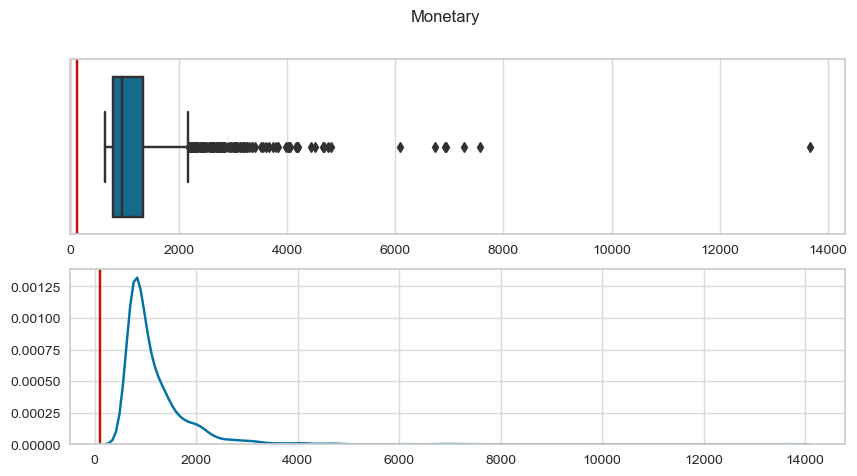

------------------
Segment 2
------------------

(51787, 9)
Recency
------------------
count   51787.0000
mean      132.4977
std        72.5650
min         4.0000
25%        69.0000
50%       134.0000
75%       194.0000
max       262.0000
Name: Recency, dtype: float64


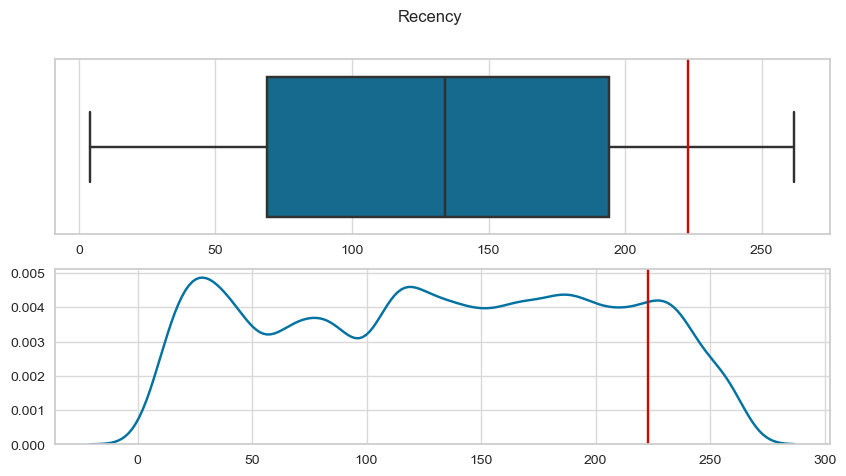

Frequency
------------------
count   51787.0000
mean        1.0000
std         0.0000
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: Frequency, dtype: float64


/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/2338447943.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=feature_subset, ax=ax2)


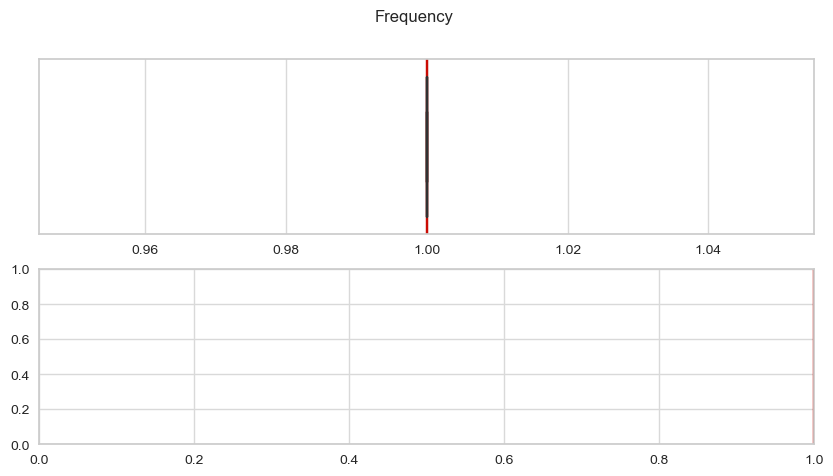

Monetary
------------------
count   51787.0000
mean      134.7169
std       107.6465
min         9.5900
25%        61.2200
50%       103.8300
75%       170.6300
max       692.9400
Name: Monetary, dtype: float64


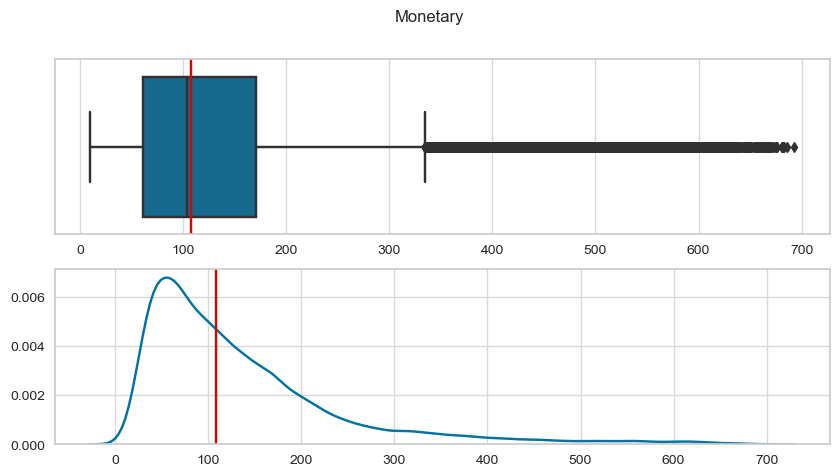

------------------
Segment 3
------------------

(2881, 9)
Recency
------------------
count   2881.0000
mean     225.2072
std      144.4574
min        0.0000
25%      110.0000
50%      204.0000
75%      324.0000
max      696.0000
Name: Recency, dtype: float64


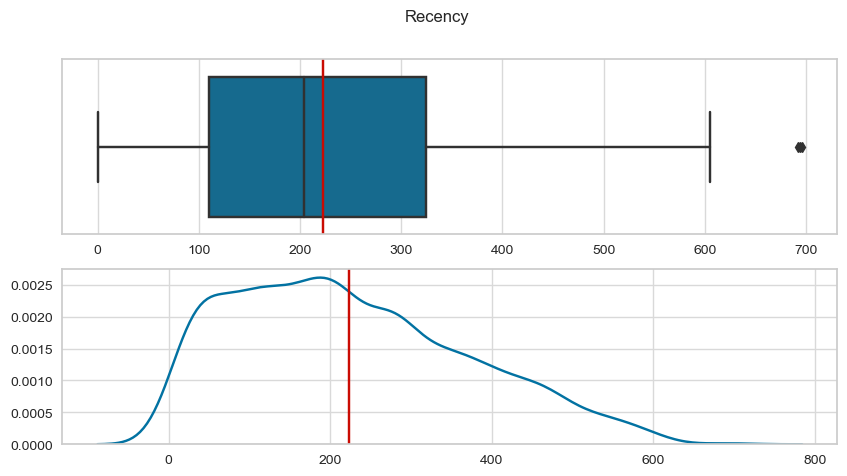

Frequency
------------------
count   2881.0000
mean       2.1149
std        0.5093
min        2.0000
25%        2.0000
50%        2.0000
75%        2.0000
max       16.0000
Name: Frequency, dtype: float64


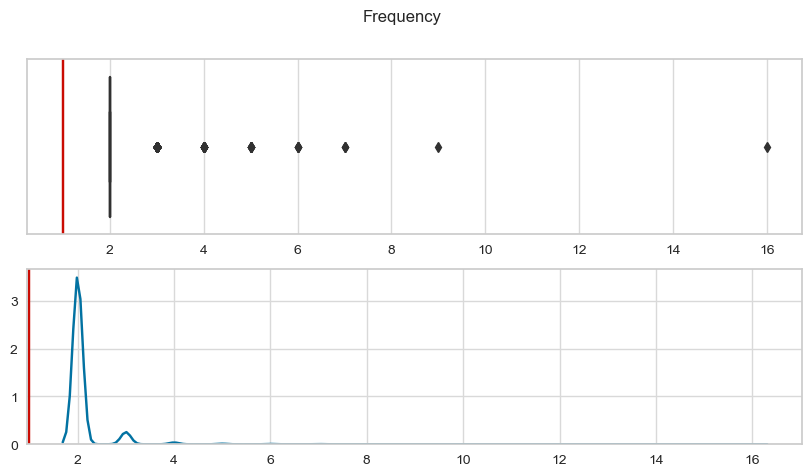

Monetary
------------------
count   2881.0000
mean     289.6197
std      225.1518
min       34.9700
25%      145.3500
50%      223.9900
75%      355.1900
max     2400.4800
Name: Monetary, dtype: float64


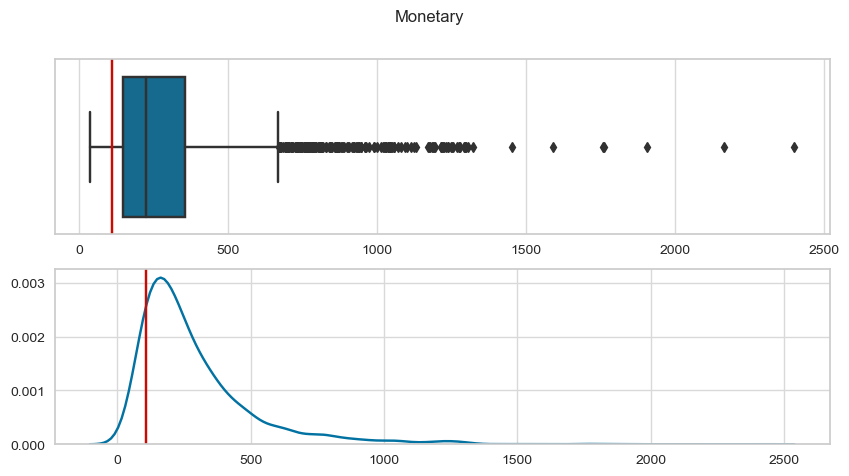

In [328]:
for segment in segments:
    print('------------------')
    print(f'Segment {segment}')
    print('------------------')
    print('')

    subset = df_rfm.loc[df_rfm['Segment_RFM_4'] == segment]
    print(subset.shape)

    for feature in rfm_features:
        print(f'{feature}')
        print('------------------')

        feature_subset = subset[feature]
        print(feature_subset.describe())

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
        fig.suptitle(feature, fontsize=12)

        feature_median = df_rfm[feature].median()

        sns.boxplot(x=feature_subset, ax=ax1)
        ax1.axvline(feature_median, c='r')
        ax1.set(xlabel=None)

        sns.kdeplot(x=feature_subset, ax=ax2)
        ax2.axvline(feature_median, c='r')
        ax2.set(xlabel=None)
        ax2.set(ylabel=None)
        plt.show()

We can roughly define clusters with the following caracteristics:

- cluster 0: high recency, average frequency, average monetary
- cluster 1: average recency, average frequency, the highest monetary
- cluster 2: low recency, average frequency, average monetary
- cluster 3: average recency, high frequency, slightly more than average monetary

Let's see the different features in comparison.

**Recency**

In [116]:
df_rfm['Segment_RFM_4'] = df_rfm['Segment_RFM_4'].astype(str)

<Figure size 1500x500 with 0 Axes>

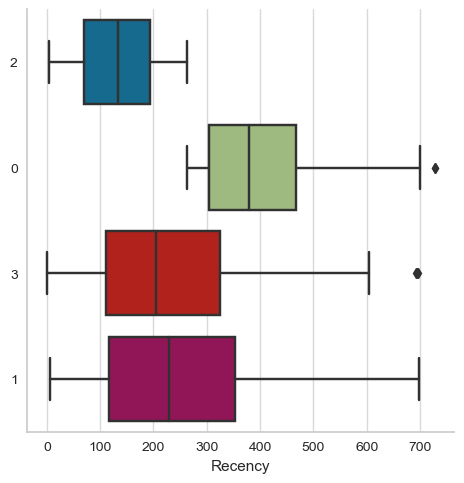

In [117]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm, x="Recency", y="Segment_RFM_4", kind="box")

plt.ylabel(ylabel='')
plt.show()

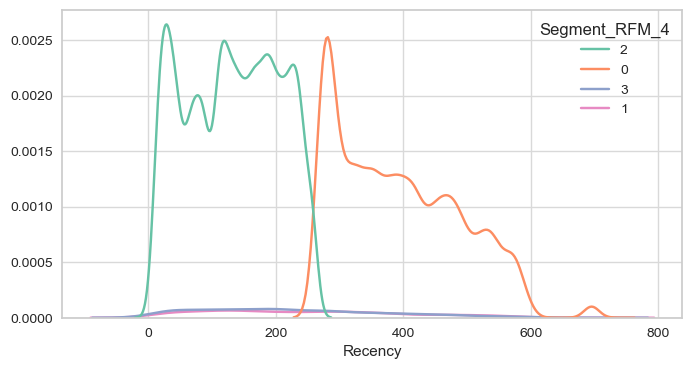

In [118]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=df_rfm, x="Recency", hue="Segment_RFM_4", palette="Set2")
plt.ylabel(ylabel=None)

plt.show()

Cluster 2 represents low recency and cluster 0 a high recency, clusters 1 and 3 have an average recency.

**Frequency**

<Figure size 1500x500 with 0 Axes>

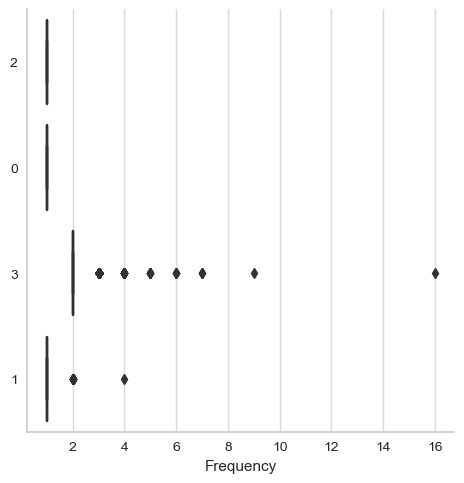

In [119]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm, x="Frequency", y="Segment_RFM_4", kind="box")

plt.ylabel(ylabel='')
plt.show()

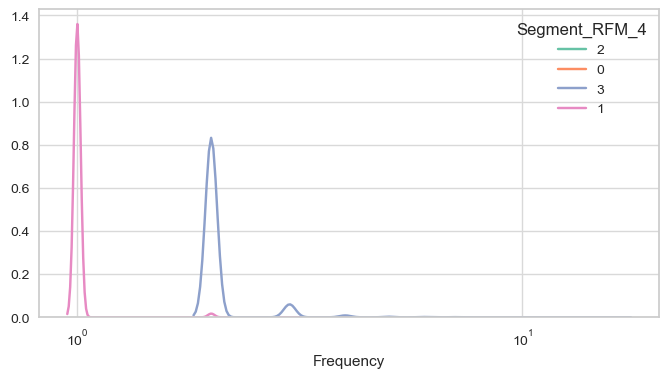

In [120]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=df_rfm, x="Frequency", hue="Segment_RFM_4",
            palette="Set2", log_scale=True, warn_singular=False)
plt.ylabel(ylabel=None)

plt.show()

Cluster 3 differs from the others by its higher than average frequency.

**Monetary**

<Figure size 1500x500 with 0 Axes>

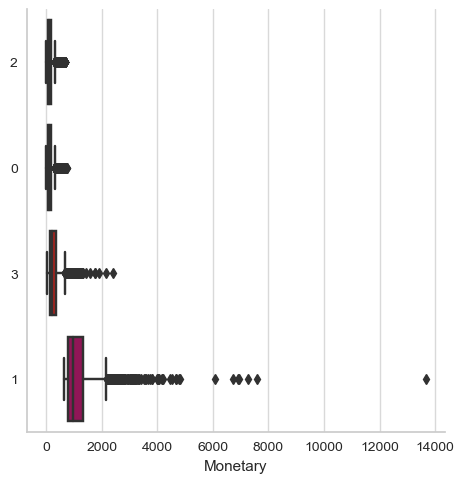

In [121]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm, x="Monetary", y="Segment_RFM_4", kind="box")

plt.ylabel(ylabel='')
plt.show()

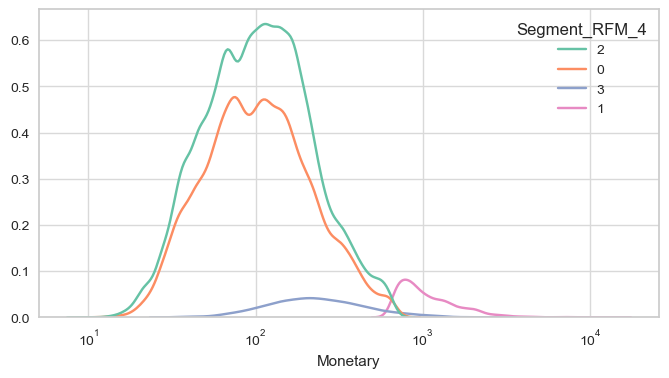

In [122]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=df_rfm, x="Monetary", hue="Segment_RFM_4",
            palette="Set2", log_scale=True)
plt.ylabel(ylabel=None)

plt.show()

Cluster 1 has the highest monetary values, followed by cluster 3. Cluster 0 and 2 have average monetary values.

**Clusters description**

Given the distribution plots above, we can elaborate on the initial assumption of customers profiles:

**Cluster 0** <br/>
This group represents 40% of all customers. These are the oldest clients who have passed only 1 order more than 8 months ago and didn't renew. Their monetary value is average. We can call them **Desengaged clients**.<br/>


**Cluster 1** <br/>
The group 1 represents only 3% of all clients, and they are the best spenders of the platform. Their recency is spread through all the period, they passed only 1 order but have spent the most comparing to the other clients. We can call them **the best spenders**<br/>

**Cluster 2** <br/>
This is the largest group and represents 54% of the clients. These are the most recent clients that have passed 1 order and have an average monetary value. We will refer to them as **New clients** <br/>

**Cluster 3** <br/>
The group 3 represents 3%, and includes customers who made more that 1 order. Their recency is spread all over the period and their monetary value is above the average but less than the best spenders. These are the most **loyal clients**. 

## RFM + Satisfaction

Let's see if Satisfaction brings a more valuable and interesting client segmentation.

In [123]:
scaler_rfms = StandardScaler()
X_rfms_scaled = scaler_rfms.fit_transform(df_rfm[rfms_features])
X_rfms_scaled

array([[-0.83312584, -0.16104597, -0.10585274,  0.68041877],
       [-0.81353754, -0.16104597, -0.60821607, -0.07612273],
       [ 1.94841326, -0.16104597, -0.34969888, -0.83266423],
       ...,
       [ 2.15082573, -0.16104597, -0.23478289,  0.68041877],
       [-0.78089037, -0.16104597, -0.14180779,  0.68041877],
       [ 1.60235323, -0.16104597, -0.41390119,  0.68041877]])

### Choosing number of clusters

cluster 2: 0.6572526180534889 score
cluster 3: 0.4121336177883162 score
cluster 4: 0.39483963841938585 score
cluster 5: 0.4174267028092459 score
cluster 6: 0.4242770150631729 score
cluster 7: 0.35086271907431904 score
cluster 8: 0.3410387334505433 score
cluster 9: 0.3525516377073412 score
cluster 10: 0.362467490135044 score


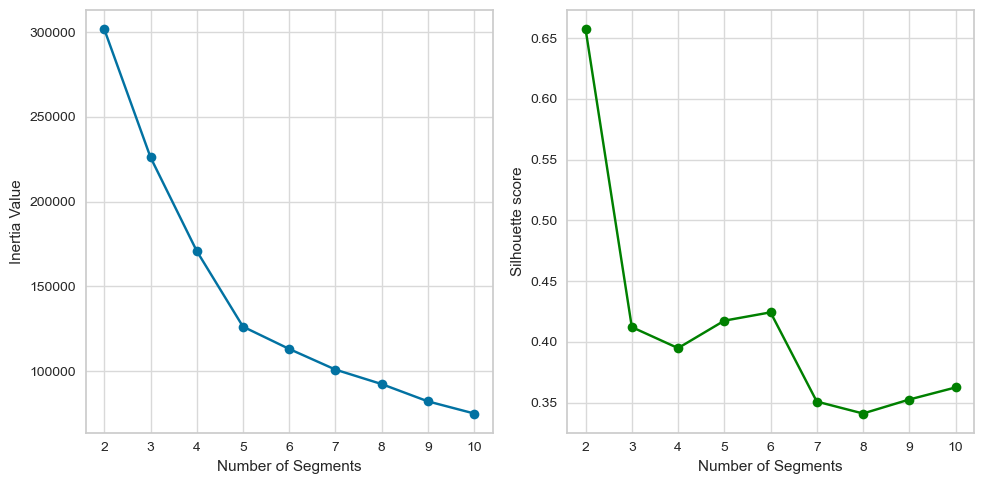

In [124]:
get_clusters(X_rfms_scaled, max_cluster=11)

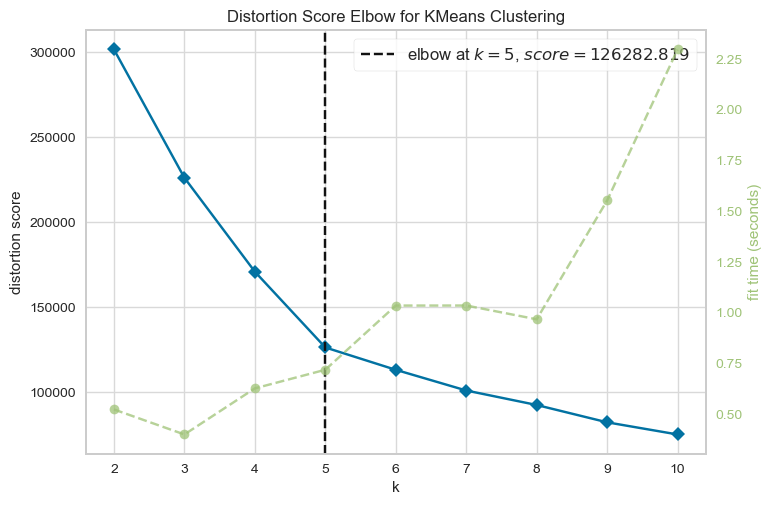

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init=10, random_state=0),
                 k=(2, 11))

In [125]:
kelbow_visualizer(KMeans(random_state=0, n_init=10), X_rfms_scaled, k=(2, 11))

The distortion graph indicates 5 as the best number of clusters but the best silhouette score goes for 6, let's analyse both configurations.

### 5 clusters

In [126]:
time_before = time.time()

model_rfms5 = KMeans(n_clusters=5, random_state=0, n_init=10)
y_rfms5 = model_rfms5.fit_predict(X_rfms_scaled)
score_rfms5 = silhouette_score(X_rfms_scaled, y_rfms5)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

print(score_rfms5)

df_rfm["Segment_RFMS_5"] = y_rfms5
df_rfm.head(10)

execution time: 59.0776 seconds
0.4174267028092459


,Recency,Frequency,Monetary,Satisfaction,Segment_RFM_4,Segment_RFM_3,Segment_RFMS_5
0,115,1,141.9000,5.0000,2,2,0
1,118,1,27.1900,4.0000,2,2,0
2,541,1,86.2200,3.0000,0,0,1
3,325,1,43.6200,4.0000,0,0,1
4,292,1,196.8900,5.0000,0,0,1
5,150,1,166.9800,4.0000,2,2,0
6,135,1,35.3800,4.0000,2,2,0
7,186,1,419.1800,1.0000,2,2,4
8,547,1,150.1200,4.0000,0,0,1
9,174,1,129.7600,1.0000,2,2,4


In [127]:
df_rfm[rfms_features].describe()

,Recency,Frequency,Monetary,Satisfaction
count,95419.0000,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705,4.1006
std,153.1534,0.2112,228.3419,1.3218
min,0.0000,1.0000,9.5900,1.0000
25%,118.0000,1.0000,63.1000,4.0000
50%,223.0000,1.0000,107.9500,5.0000
75%,352.0000,1.0000,183.2700,5.0000
max,728.0000,16.0000,13664.0800,5.0000


In [128]:
df_rfm[rfms_features + ['Segment_RFMS_5']].groupby("Segment_RFMS_5").mean()

,Recency,Frequency,Monetary,Satisfaction
Segment_RFMS_5,,,,
0,126.3835,1.0000,133.0450,4.6702
1,397.3414,1.0000,134.1323,4.6267
2,225.2072,2.1149,289.6197,4.1177
3,241.2046,1.0163,1257.8439,4.0057
4,243.4593,1.0000,152.4494,1.6204


We can roughly define the following groups:

- segment 0: the most recent, avg frequency, avg monetary, above avg score
- segment 1: the oldest, avg frequency, avg monetary, above avg score
- segment 2: avg recency, the best frequency, above avg monetary, avg score
- segment 3: avg recency, avg frequency, excellent monetary, the avg score
- segment 4: avg recency, avg frequency, avg monetary, the worst score

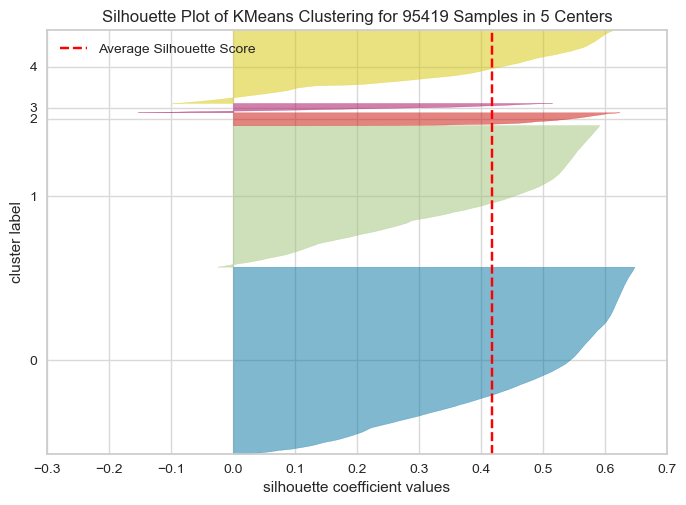

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 95419 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, n_init=10, random_state=0))

In [129]:
silhouette_visualizer(model_rfms5, X_rfms_scaled, colors='yellowbrick')

Clusters 0 and 1 are the biggest, followed by cluster 4. Cluster 3 is the smallest and the most uncertain, its points have the weakest silhouette values that go below 0 for certain points.

In [130]:
df_rfm['Segment_RFMS_5'].value_counts()

0    42154
1    31908
4    16389
2     2881
3     2087
Name: Segment_RFMS_5, dtype: int64

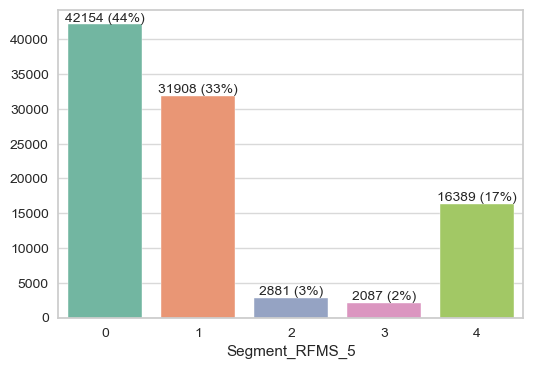

In [232]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm['Segment_RFMS_5'].sort_values(), ax=ax, palette="Set2")
ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f} ({:.0f}%)'.format(x, x/df_rfm.shape[0]*100), fontsize=10
)

plt.ylabel(ylabel=None)
plt.show()

In [241]:
labels = cluster_value_counts.index
new_labels = map(lambda x: 'Segment ' + x, labels)
new_labels

([<matplotlib.patches.Wedge at 0x2a853dd20>,
 [Text(0.20008126010925267, 1.081650354482951, 'Segment 0'),
  Text(-0.8520527848991629, -0.6957054346097787, 'Segment 1'),
  Text(0.712055485018041, -0.838437228572135, 'Segment 4'),
  Text(1.0704584754729576, -0.253216611398446, 'Segment 2'),
  Text(1.0974042330778409, -0.07552449419119536, 'Segment 3')],
 [Text(0.10913523278686509, 0.589991102445246, '44%'),
  Text(-0.4647560644904524, -0.3794756916053338, '33%'),
  Text(0.3883939009189314, -0.4573293974029827, '17%'),
  Text(0.5838864411670678, -0.1381181516718796, '3%'),
  Text(0.5985841271333677, -0.041195178649742925, '2%')])

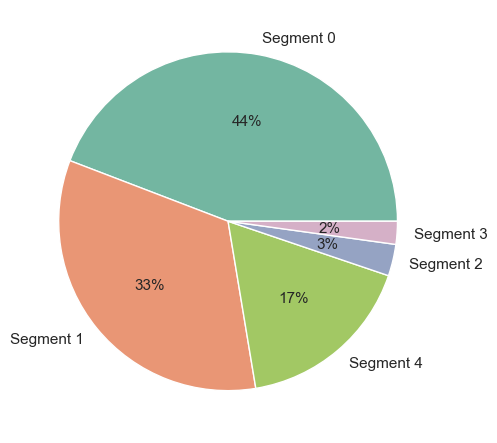

In [243]:
cluster_value_counts = df_rfm['Segment_RFMS_5'].value_counts()
labels = cluster_value_counts.index

plt.pie(
    cluster_value_counts.values,
    labels=list(map(lambda x: 'Segment ' + x, cluster_value_counts.index)),
    autopct='%.0f%%',
    colors=['#73B6A1', '#E99675', '#A2C864', '#95A3C3', '#D5B0C7'],
    textprops={'size': 11},
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

If we compare with the 4 cluster segmentation, we have an additional group here for the clients with a low satisfaction score that represent 17% of all customers.

### 6 clusters

In [132]:
time_before = time.time()

model_rfms6 = KMeans(n_clusters=6, random_state=0, n_init=10)
y_rfms6 = model_rfms6.fit_predict(X_rfms_scaled)
score_rfms6 = silhouette_score(X_rfms_scaled, y_rfms6)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

print(score_rfms6)

df_rfm["Segment_RFMS_6"] = y_rfms6
df_rfm.head(10)

execution time: 58.669 seconds
0.4242770150631729


,Recency,Frequency,Monetary,Satisfaction,Segment_RFM_4,Segment_RFM_3,Segment_RFMS_5,Segment_RFMS_6
0,115,1,141.9000,5.0000,2,2,0,0
1,118,1,27.1900,4.0000,2,2,0,0
2,541,1,86.2200,3.0000,0,0,1,4
3,325,1,43.6200,4.0000,0,0,1,4
4,292,1,196.8900,5.0000,0,0,1,4
5,150,1,166.9800,4.0000,2,2,0,0
6,135,1,35.3800,4.0000,2,2,0,0
7,186,1,419.1800,1.0000,2,2,4,5
8,547,1,150.1200,4.0000,0,0,1,4
9,174,1,129.7600,1.0000,2,2,4,5


In [133]:
df_rfm[rfms_features].describe()

,Recency,Frequency,Monetary,Satisfaction
count,95419.0000,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705,4.1006
std,153.1534,0.2112,228.3419,1.3218
min,0.0000,1.0000,9.5900,1.0000
25%,118.0000,1.0000,63.1000,4.0000
50%,223.0000,1.0000,107.9500,5.0000
75%,352.0000,1.0000,183.2700,5.0000
max,728.0000,16.0000,13664.0800,5.0000


In [134]:
df_rfm[rfms_features + ['Segment_RFMS_6']].groupby("Segment_RFMS_6").mean()

,Recency,Frequency,Monetary,Satisfaction
Segment_RFMS_6,,,,
0,126.2364,1.0000,123.3680,4.6694
1,225.1513,2.1139,291.8524,4.1177
2,240.8459,1.0000,781.9966,4.1951
3,238.6080,1.0646,2219.9358,3.7016
4,397.6556,1.0000,124.1298,4.6259
5,243.5177,1.0000,144.5277,1.6116


We can roughly define the following groups of customers: <br/>
- segment 0: the most recent, avg frequency, avg monetary, above avg score
- segment 1: avg recency, the best frequency, above avg monetary, avg score
- segment 2: avg recency, avg frequency, good monetary, avg score
- segment 3: avg recency, avg frequency, the best monetary, below avg score
- segment 4: the oldest, avg frequency, avg recency, above avg score
- segment 5: avg recency, avg frequency, avg monetary, the worst score

Comparing to the previous segmentation with 5 clusters, we see almost the same groups plus a new division for the clients with the best monetary value and below the average score.

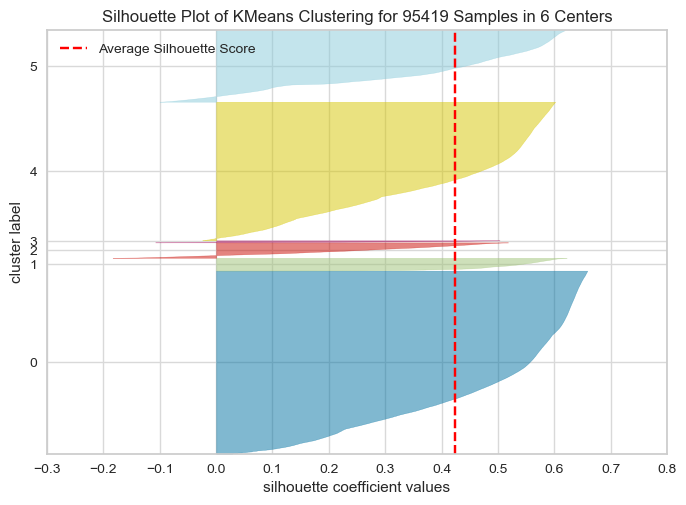

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 95419 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, n_init=10, random_state=0))

In [135]:
silhouette_visualizer(model_rfms6, X_rfms_scaled, colors='yellowbrick')

In [136]:
df_rfm['Segment_RFMS_6'].value_counts()

0    41267
4    31247
5    16103
2     3465
1     2888
3      449
Name: Segment_RFMS_6, dtype: int64

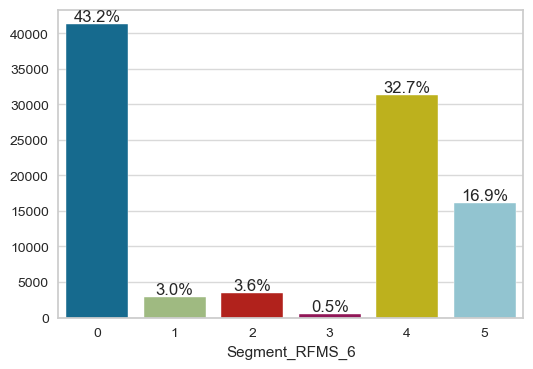

In [137]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm['Segment_RFMS_6'], ax=ax)

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.1f}%'.format(x/df_rfm.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

The group 3 is the smallest and includes only 449 clients (0.5%), these are the **best spenders** who are slightly dissatisfied, they are very close to the group 2, so it is more consistent from the domain point of view to keep 5 clusters.

### 5 segments analysis

As for the RFM clustering with 4 segments, let's do the same analysis to get a better idea of the value brought by the satisfaction feature.

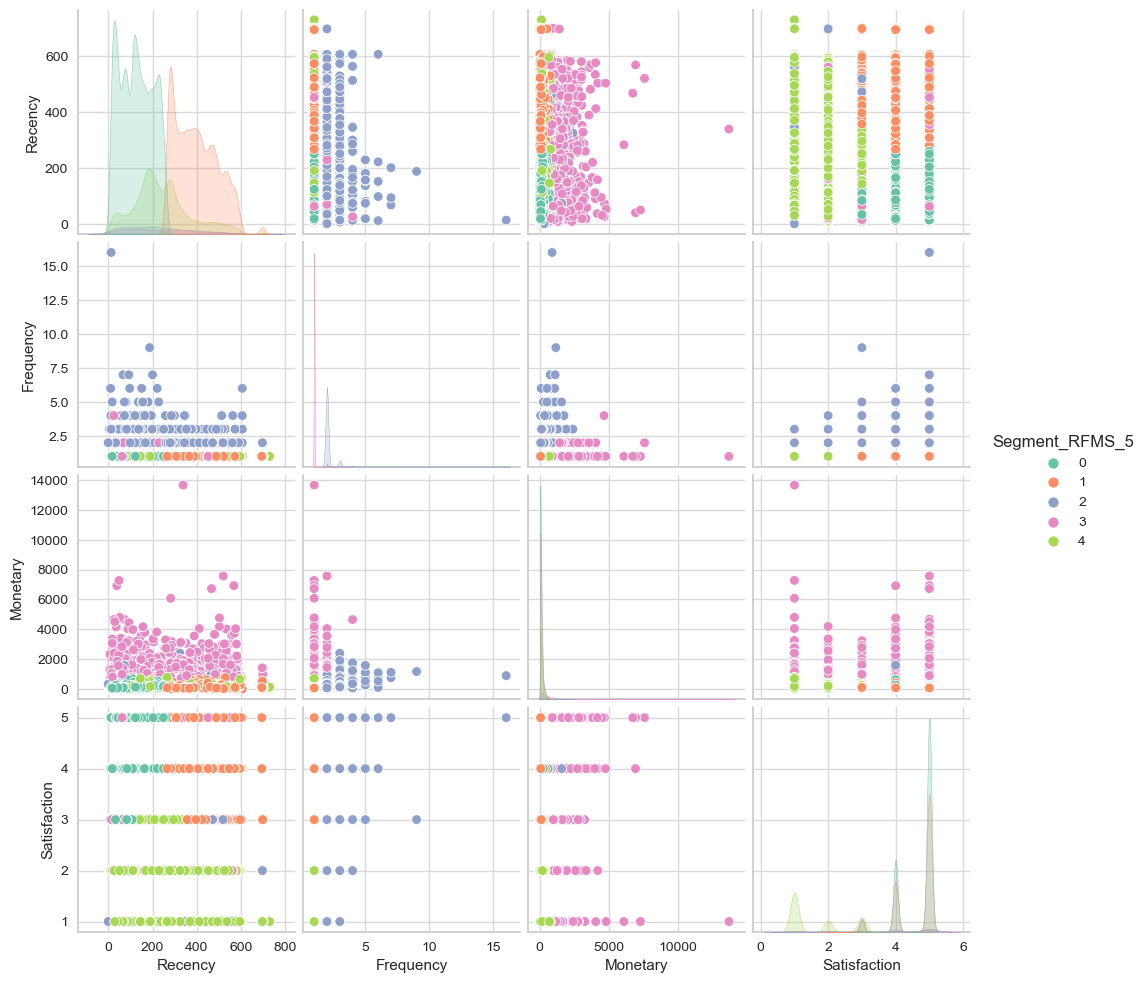

In [138]:
sns.pairplot(df_rfm[rfms_features + ['Segment_RFMS_5']],
             hue="Segment_RFMS_5", palette="Set2")

We can observe the same tendencies as for the 4 clusters in the Recency/Frequency/Monetary features :

1. Clear separation of the cluster 0 (most recent) and cluster 1 (the oldest) on the Recency graph.
2. No particular relation on Monetary or Frequency with the Recency.
3. Separation of the cluster 3 (rose - high spenders) from other clusters along the Monetary axis.
4. Separation of the cluster 2 (blue - high frequency) on the Frequency graph from other clusters
5. Small relation between Frequency and Monetary for the cluster 2 (blue - high frequency)
6. Separation of the cluster 4 on the Satisfaction axis which has the lowest values for the review score.

The satisfaction feature brings quite interesting information to the customer profile even if the average review score is quite good (4) in general. Moreover, it has a certain influence as to the quality of clusters. 

**Distribution of features inside clusters**

The red line represents the global median value for the feature

In [348]:
segments = df_rfm['Segment_RFMS_5'].sort_values().unique()
segments

array(['0', '1', '2', '3', '4'], dtype=object)

In [331]:
df_rfm[rfms_features].describe()

,Recency,Frequency,Monetary,Satisfaction
count,95419.0000,95419.0000,95419.0000,95419.0000
mean,242.5954,1.0340,166.0705,4.1006
std,153.1534,0.2112,228.3419,1.3218
min,0.0000,1.0000,9.5900,1.0000
25%,118.0000,1.0000,63.1000,4.0000
50%,223.0000,1.0000,107.9500,5.0000
75%,352.0000,1.0000,183.2700,5.0000
max,728.0000,16.0000,13664.0800,5.0000


------------------
Cluster 0
------------------

Recency
------------------
count   42154.0000
mean      126.3835
std        72.7024
min         4.0000
25%        63.0000
50%       124.0000
75%       188.0000
max       262.0000
Name: Recency, dtype: float64


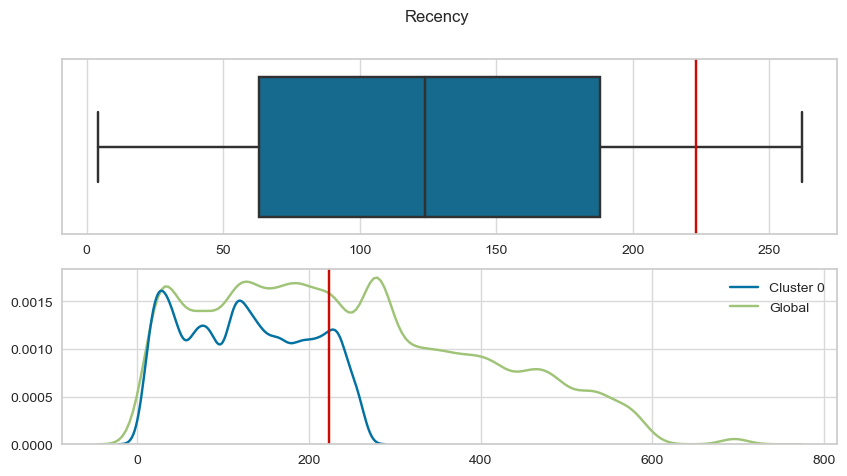

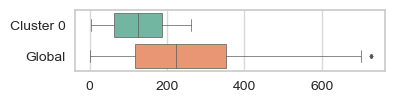

/Users/natche/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


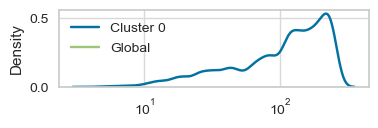

Frequency
------------------
count   42154.0000
mean        1.0000
std         0.0000
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: Frequency, dtype: float64


/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, ax=ax2)


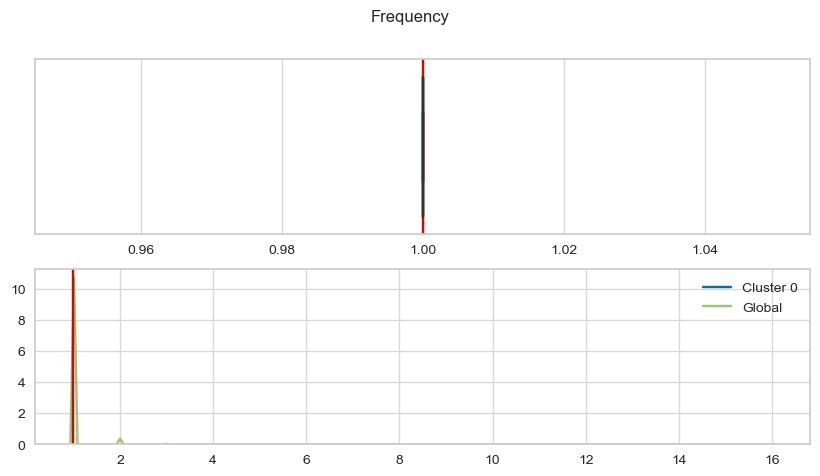

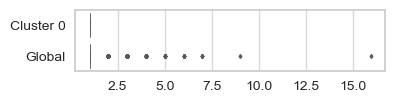

/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


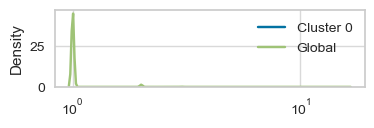

Monetary
------------------
count   42154.0000
mean      133.0450
std       108.6781
min         9.5900
25%        59.6000
50%       102.1300
75%       167.8100
max       739.7900
Name: Monetary, dtype: float64


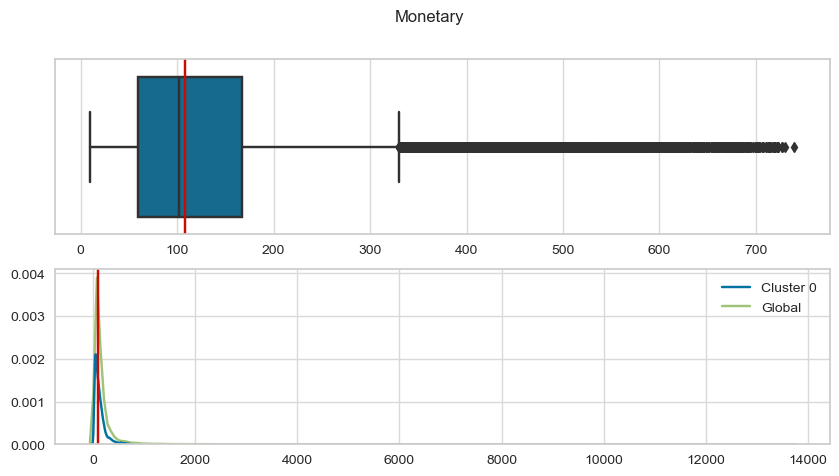

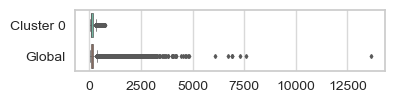

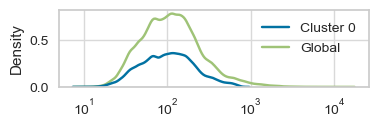

Satisfaction
------------------
count   42154.0000
mean        4.6702
std         0.5566
min         3.0000
25%         4.0000
50%         5.0000
75%         5.0000
max         5.0000
Name: Satisfaction, dtype: float64


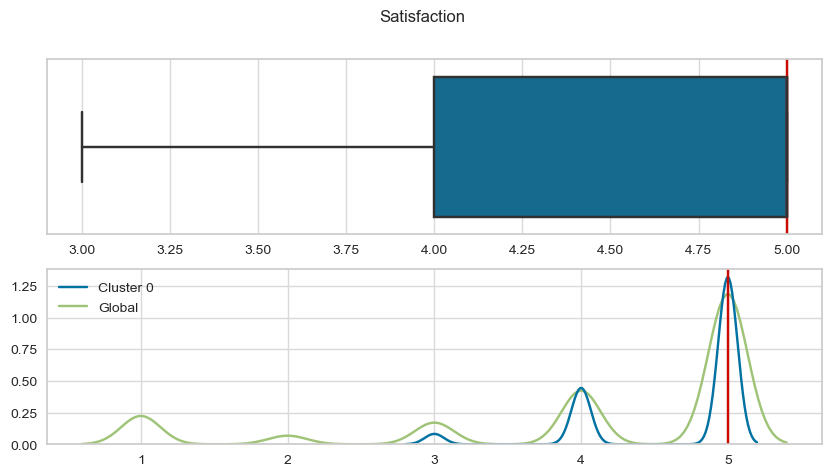

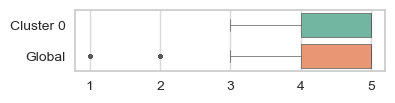

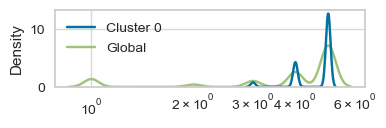

------------------
Cluster 1
------------------

Recency
------------------
count   31908.0000
mean      397.3414
std        95.2925
min       261.0000
25%       313.0000
50%       387.0000
75%       469.2500
max       699.0000
Name: Recency, dtype: float64


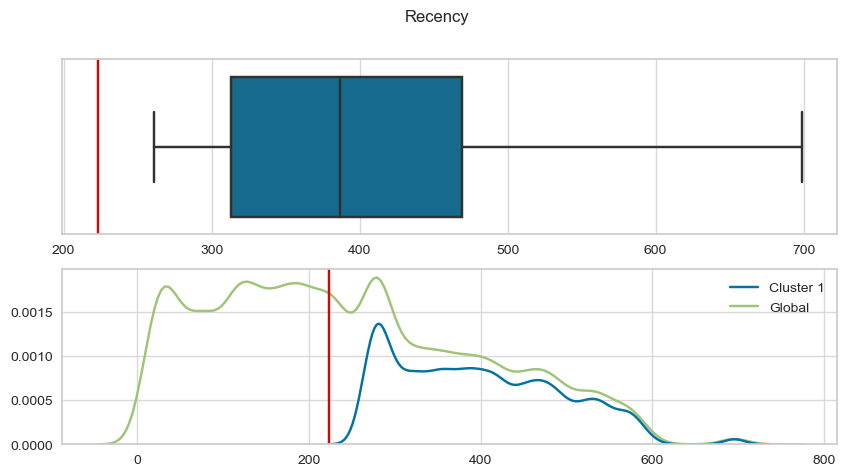

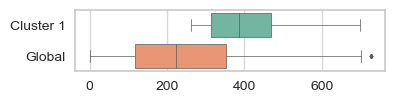

/Users/natche/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


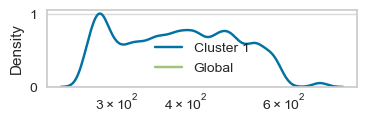

Frequency
------------------
count   31908.0000
mean        1.0000
std         0.0000
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: Frequency, dtype: float64


/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, ax=ax2)


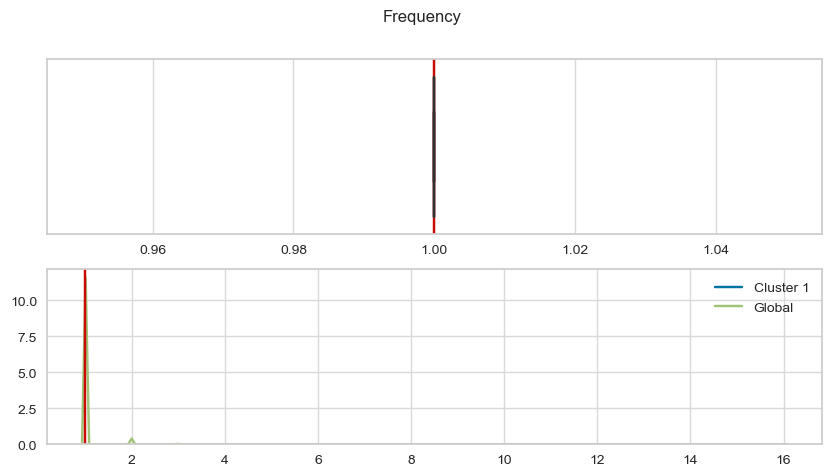

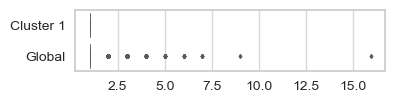

/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


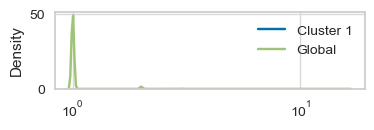

Monetary
------------------
count   31908.0000
mean      134.1323
std       112.8104
min        10.0700
25%        60.7475
50%       100.3400
75%       165.7000
max       818.1200
Name: Monetary, dtype: float64


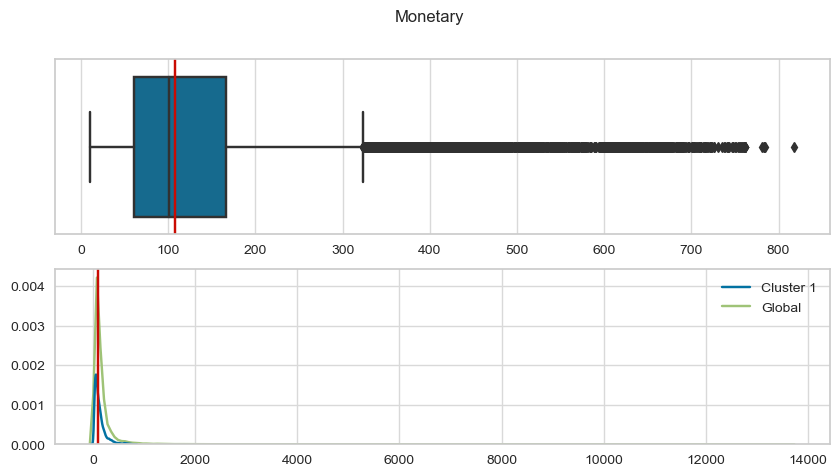

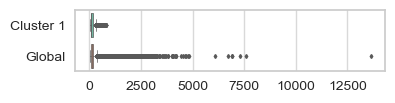

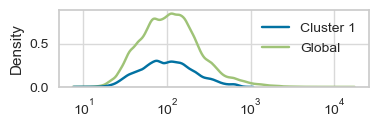

Satisfaction
------------------
count   31908.0000
mean        4.6267
std         0.5955
min         2.0000
25%         4.0000
50%         5.0000
75%         5.0000
max         5.0000
Name: Satisfaction, dtype: float64


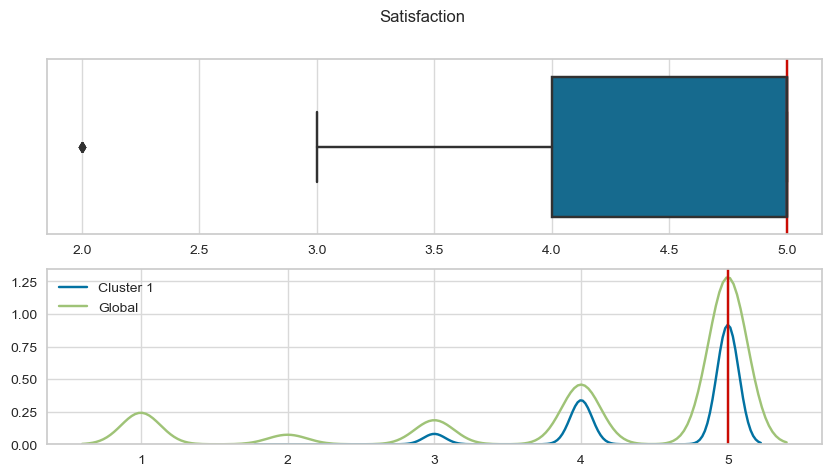

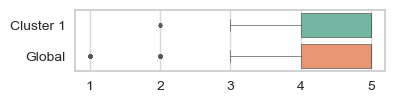

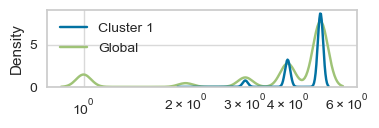

------------------
Cluster 2
------------------

Recency
------------------
count   2881.0000
mean     225.2072
std      144.4574
min        0.0000
25%      110.0000
50%      204.0000
75%      324.0000
max      696.0000
Name: Recency, dtype: float64


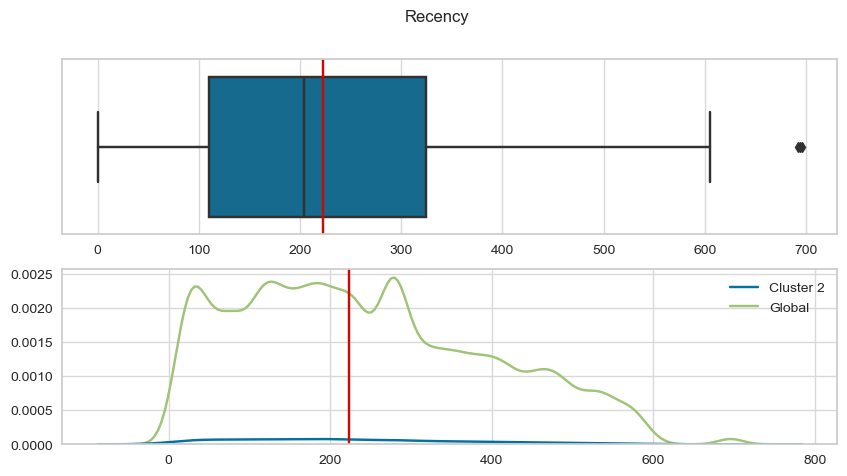

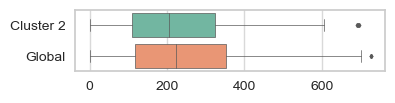

/Users/natche/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


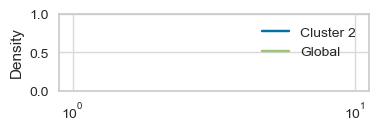

Frequency
------------------
count   2881.0000
mean       2.1149
std        0.5093
min        2.0000
25%        2.0000
50%        2.0000
75%        2.0000
max       16.0000
Name: Frequency, dtype: float64


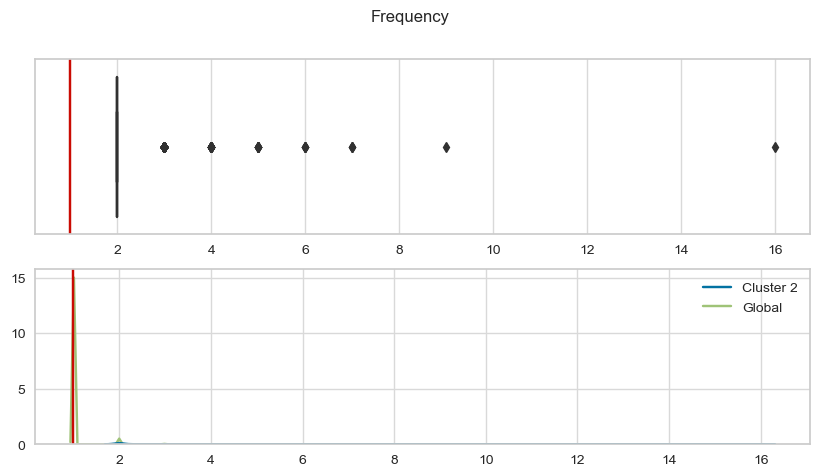

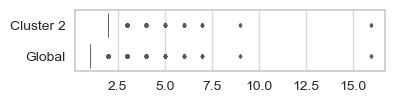

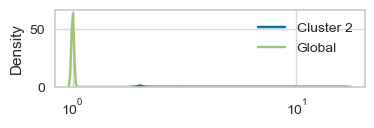

Monetary
------------------
count   2881.0000
mean     289.6197
std      225.1518
min       34.9700
25%      145.3500
50%      223.9900
75%      355.1900
max     2400.4800
Name: Monetary, dtype: float64


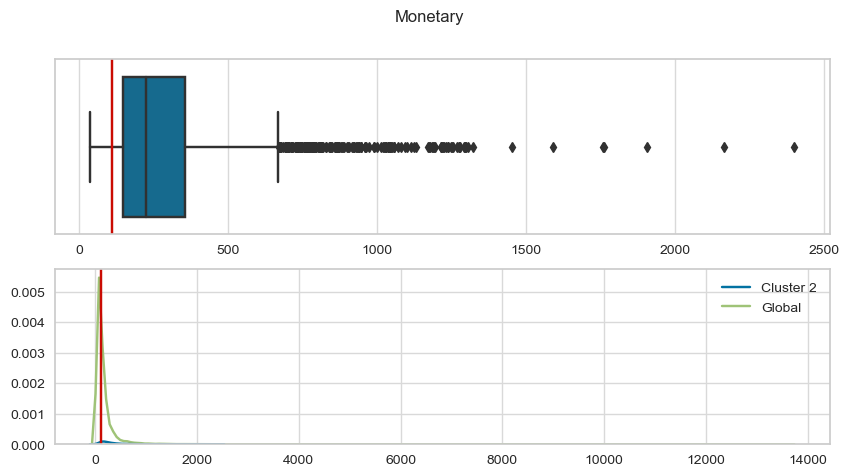

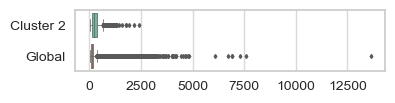

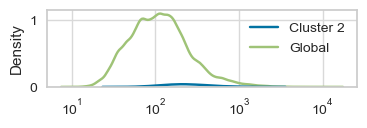

Satisfaction
------------------
count   2881.0000
mean       4.1177
std        1.1201
min        1.0000
25%        4.0000
50%        4.0000
75%        5.0000
max        5.0000
Name: Satisfaction, dtype: float64


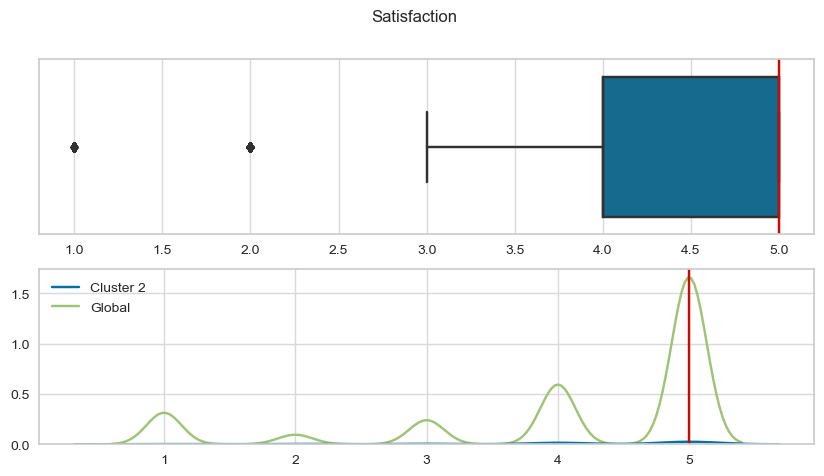

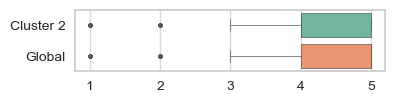

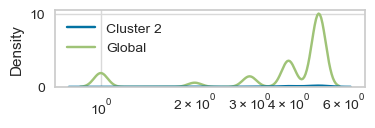

------------------
Cluster 3
------------------

Recency
------------------
count   2087.0000
mean     241.2046
std      153.2893
min        8.0000
25%      113.5000
50%      222.0000
75%      354.5000
max      698.0000
Name: Recency, dtype: float64


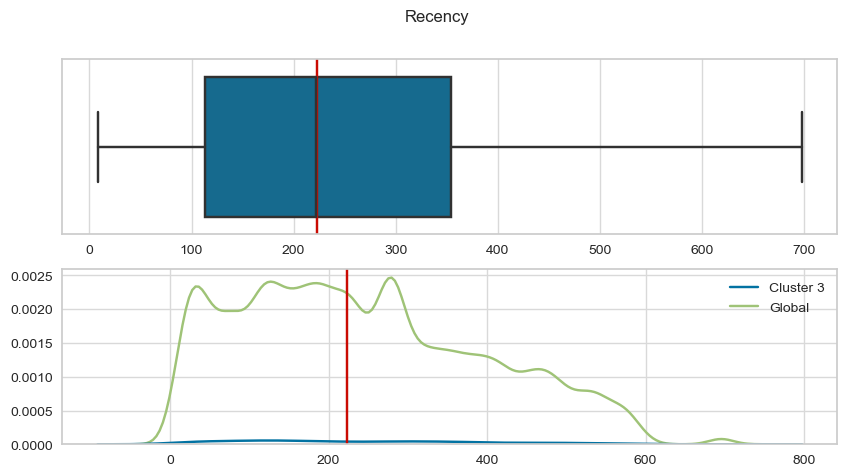

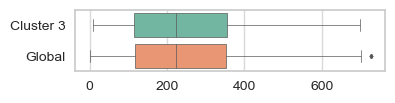

/Users/natche/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


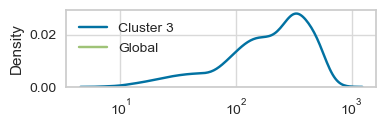

Frequency
------------------
count   2087.0000
mean       1.0163
std        0.1375
min        1.0000
25%        1.0000
50%        1.0000
75%        1.0000
max        4.0000
Name: Frequency, dtype: float64


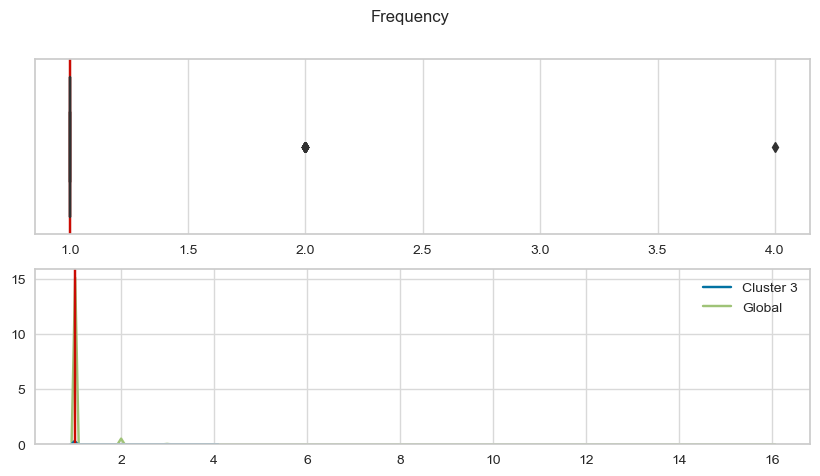

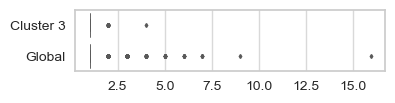

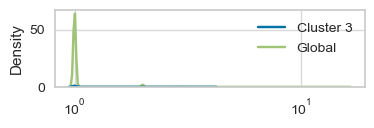

Monetary
------------------
count    2087.0000
mean     1257.8439
std       706.0553
min       681.4200
25%       847.6900
50%      1034.7200
75%      1423.5300
max     13664.0800
Name: Monetary, dtype: float64


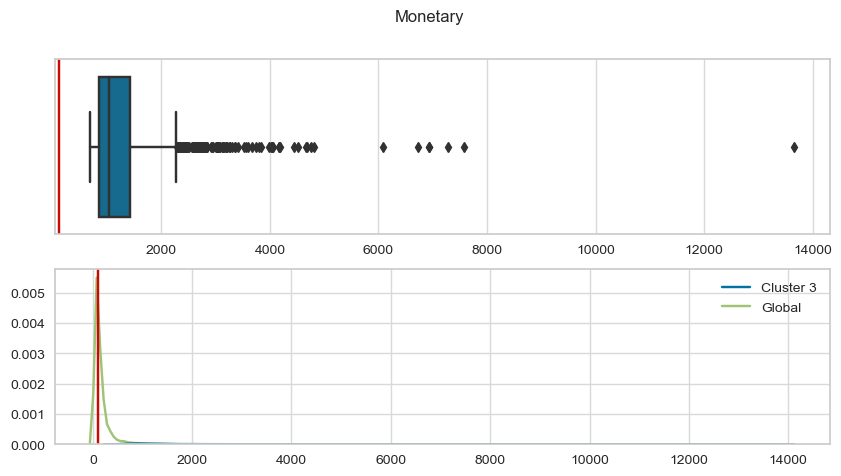

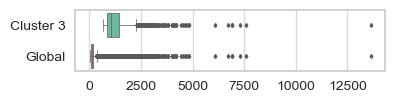

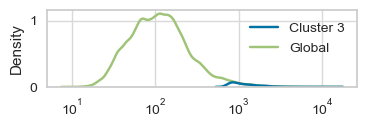

Satisfaction
------------------
count   2087.0000
mean       4.0057
std        1.4169
min        1.0000
25%        4.0000
50%        5.0000
75%        5.0000
max        5.0000
Name: Satisfaction, dtype: float64


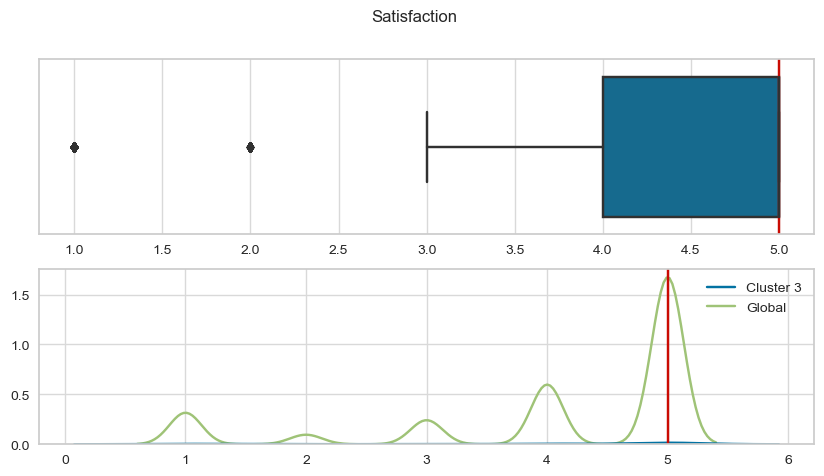

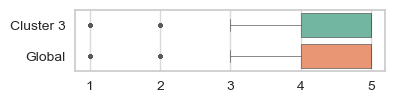

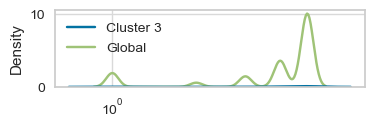

------------------
Cluster 4
------------------

Recency
------------------
count   16389.0000
mean      243.4593
std       131.2247
min         4.0000
25%       161.0000
50%       223.0000
75%       303.0000
max       728.0000
Name: Recency, dtype: float64


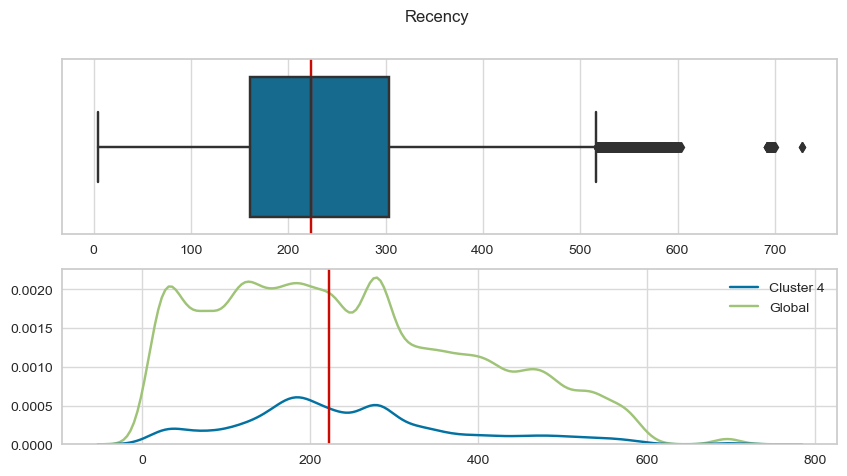

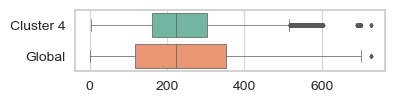

/Users/natche/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


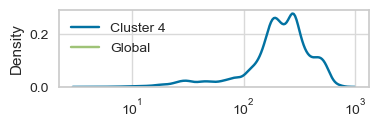

Frequency
------------------
count   16389.0000
mean        1.0000
std         0.0000
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: Frequency, dtype: float64


/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, ax=ax2)


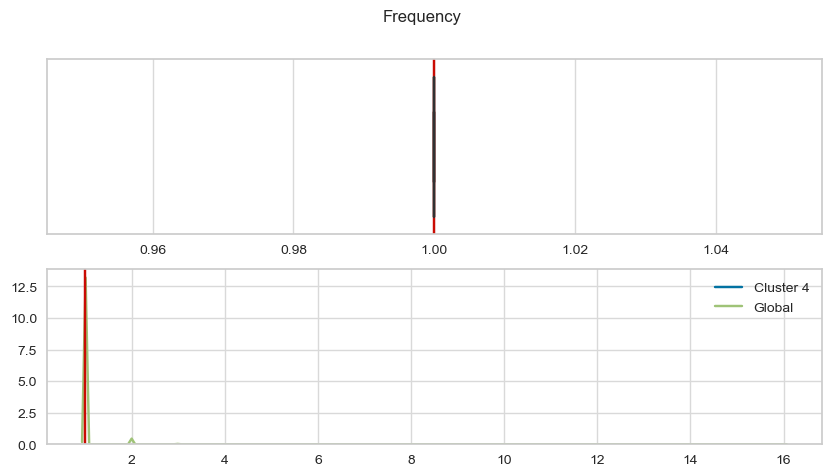

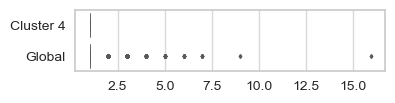

/var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/ipykernel_67672/415583744.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=concat_df, log_scale=True)


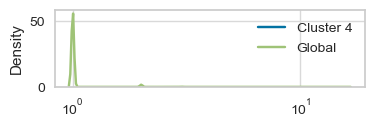

Monetary
------------------
count   16389.0000
mean      152.4494
std       128.8546
min        13.7800
25%        65.7100
50%       113.2100
75%       190.3700
max       819.4700
Name: Monetary, dtype: float64


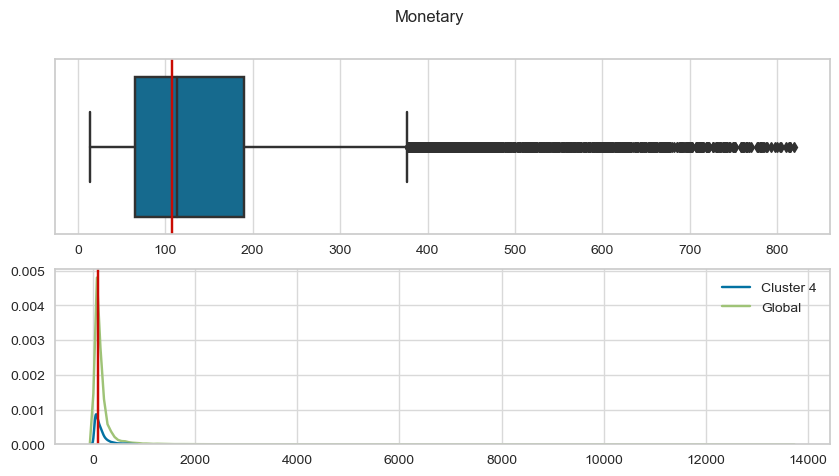

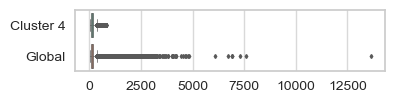

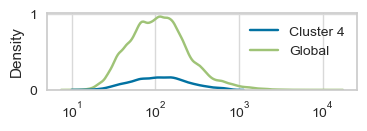

Satisfaction
------------------
count   16389.0000
mean        1.6204
std         0.8265
min         1.0000
25%         1.0000
50%         1.0000
75%         2.0000
max         3.0000
Name: Satisfaction, dtype: float64


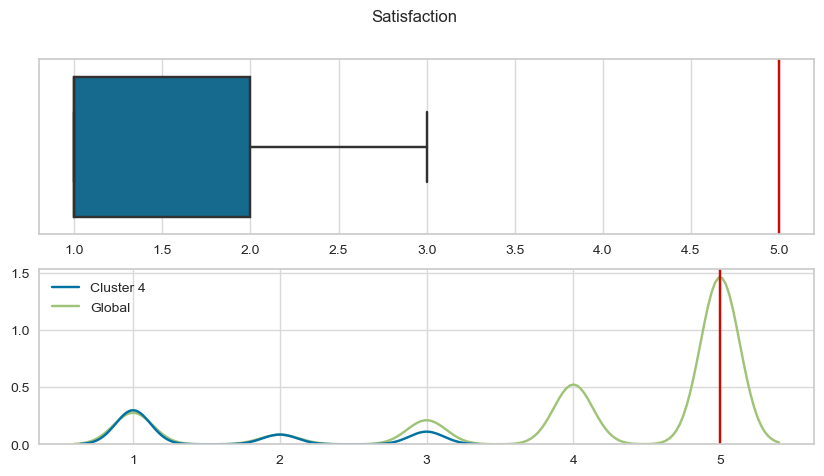

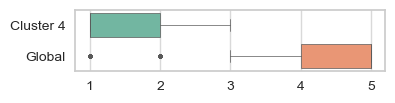

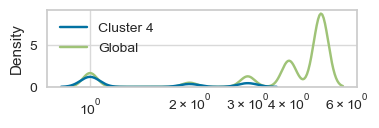

In [349]:
for segment in segments:
    segment_label = f'Cluster {segment}'
    print('------------------')
    print(segment_label)
    print('------------------')
    print('')

    subset = df_rfm.loc[df_rfm['Segment_RFMS_5'] == segment]

    for feature in rfms_features:
        print(f'{feature}')
        print('------------------')

        feature_subset = subset[feature]
        print(feature_subset.describe())

        concat_df = pd.concat(
            {
                segment_label: feature_subset,
                'Global': df_rfm[feature]
            }, axis=1)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
        fig.suptitle(feature, fontsize=12)

        feature_median = df_rfm[feature].median()

        sns.boxplot(x=feature_subset, ax=ax1)
        ax1.axvline(feature_median, c='r')
        ax1.set(xlabel=None)

        sns.kdeplot(data=concat_df, ax=ax2)
        ax2.axvline(feature_median, c='r')
        ax2.set(xlabel=None)
        ax2.set(ylabel=None)
        plt.show()

        plt.figure(figsize=(4, 0.8))
        sns.boxplot(data=concat_df,
                    orient='h',
                    linewidth=0.5,
                    fliersize=2,
                    palette="Set2")

        plt.show()

        plt.figure(figsize=(4, 1))
        sns.kdeplot(data=concat_df, log_scale=True)
        plt.show()

From the plots above, out initial assumption on cluster caracteristics are confirmed:

- cluster 0: the most recent, average frequency, average monetary, above average satisfaction
- cluster 1: the oldest, average frequency, average monetary, above average satisfaction
- cluster 2: average recency, the best frequency, above average monetary, average satisfaction
- cluster 3: average recency, average frequency, much higher than average monetary, average satisfaction
- cluster 4: average recency, average frequency, average monetary, very low satisfaction

We will get a better understanding of cluster differencies with the plots comparing all the clusters.

**Recency**

<Figure size 1500x500 with 0 Axes>

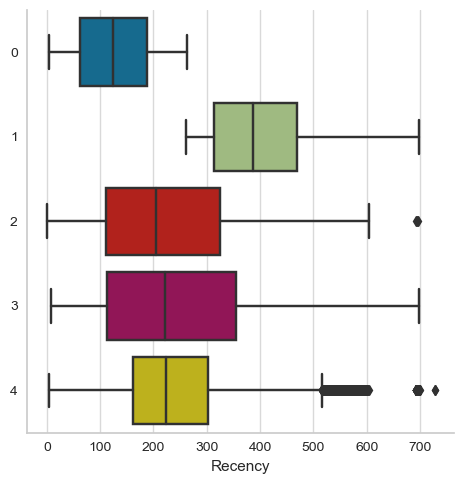

In [140]:
df_rfm['Segment_RFMS_5'] = df_rfm['Segment_RFMS_5'].astype(str)

plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm.sort_values('Segment_RFMS_5'),
            x="Recency", y="Segment_RFMS_5", kind="box")

plt.ylabel(ylabel='')
plt.show()

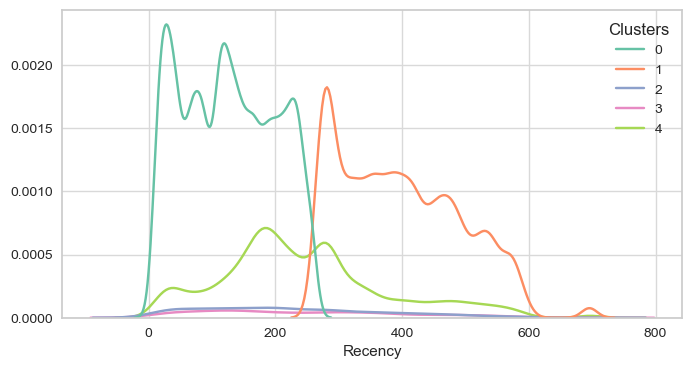

In [247]:
plt.figure(figsize=(8, 4))

g = sns.kdeplot(data=df_rfm.sort_values('Segment_RFMS_5'),
                x="Recency", hue="Segment_RFMS_5", palette="Set2")
g.legend_.set_title('Clusters')
plt.ylabel(ylabel=None)

plt.show()

We can clearly distinguish Cluster 0 with the lowest recency and Cluster 1 with the highest recency, other groups are distributed evenly.

**Frequency**

<Figure size 1500x500 with 0 Axes>

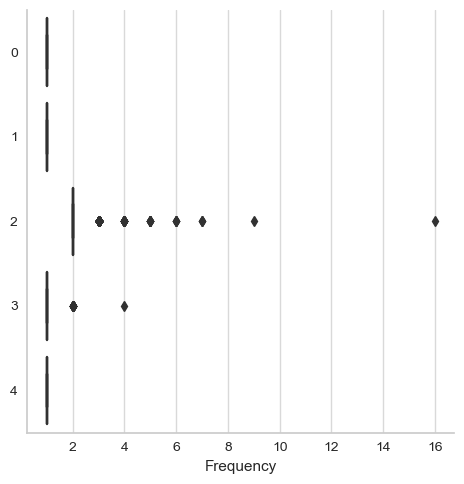

In [142]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm.sort_values('Segment_RFMS_5'),
            x="Frequency", y="Segment_RFMS_5", kind="box")

plt.ylabel(ylabel='')
plt.show()

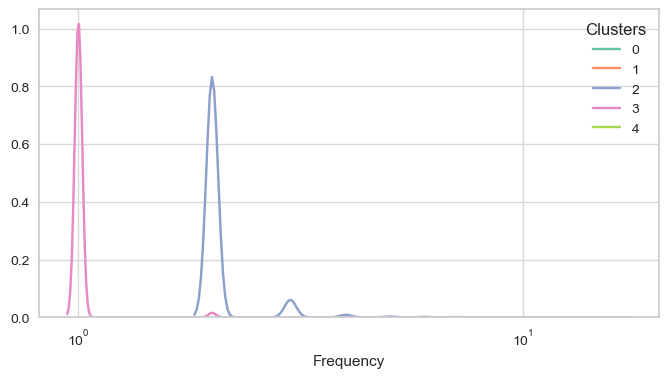

In [250]:
plt.figure(figsize=(8, 4))

g = sns.kdeplot(data=df_rfm.sort_values('Segment_RFMS_5'),
                x="Frequency",
                hue="Segment_RFMS_5",
                palette="Set2",
                log_scale=True,
                warn_singular=False)

g.legend_.set_title('Clusters')
plt.ylabel(ylabel=None)

plt.show()

Cluster 2 stands out by its high frequency.

**Monetary**

<Figure size 1500x500 with 0 Axes>

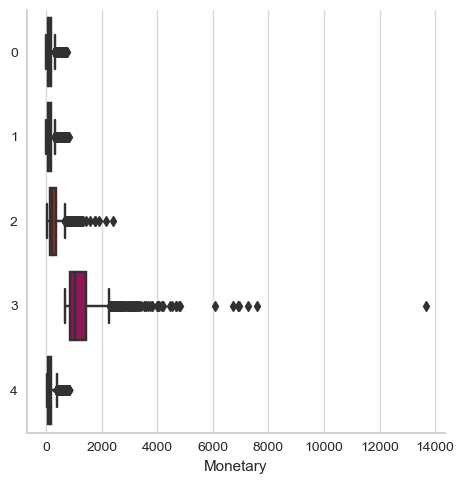

In [144]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm.sort_values('Segment_RFMS_5'),
            x="Monetary", y="Segment_RFMS_5", kind="box")

plt.ylabel(ylabel='')
plt.show()

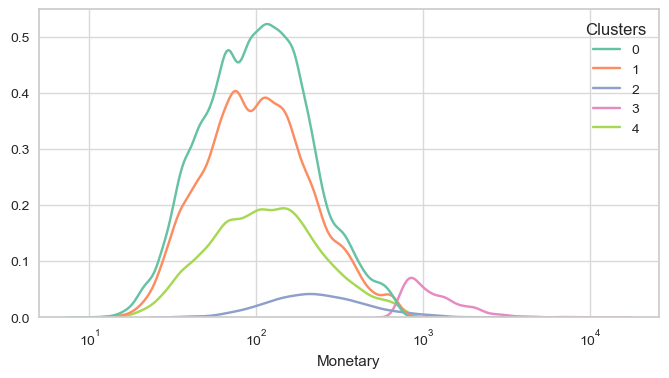

In [251]:
plt.figure(figsize=(8, 4))

g = sns.kdeplot(data=df_rfm.sort_values('Segment_RFMS_5'),
                x="Monetary",
                hue="Segment_RFMS_5",
                palette="Set2",
                log_scale=True,
                warn_singular=False)

g.legend_.set_title('Clusters')
plt.ylabel(ylabel=None)

plt.show()

Cluster 3 has the highest monetary value, followed by Cluster 2.

**Satisfaction**

<Figure size 1500x500 with 0 Axes>

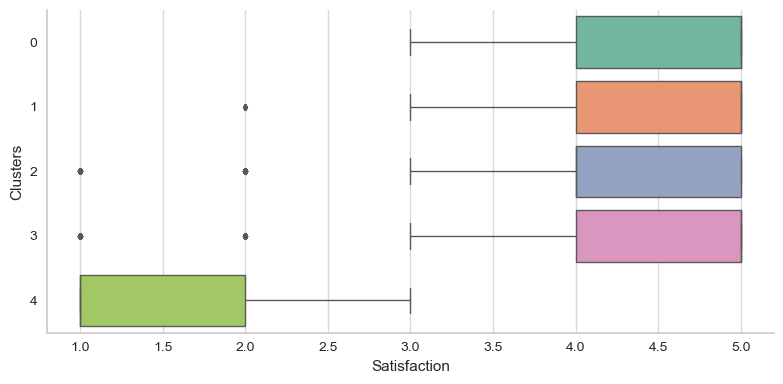

In [282]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm.sort_values('Segment_RFMS_5'),
            x="Satisfaction",
            y="Segment_RFMS_5",
            kind="box",
            height=4,
            aspect=2,
            linewidth=1,
            fliersize=3,
            palette="Set2")

plt.ylabel(ylabel='Clusters')
plt.show()

Cluster 4 has the lowest satisfaction score, Cluster 0 has the best score, Clusters 2 and 3 follow the average satisfaction.

**Clusters definition**

We can complete the previously defined segments with more detailed information:

**Cluster 0** <br/>
This is the largest group and represents 44% of the clients. These are the most recent clients that have passed 1 order and have an average monetary value. They are highly satisfied. We will refer to them as **New clients** <br/>

**Cluster 1** <br/>
The second largest group with the oldest customers of the marketplace (33%). They passed 1 order with an average payment value, they are also very happy and this is counter-intuitive and worth a further investigation to understand the churn. A possible explanation as mentioned in the Exploratory notebook might be that these customers created new accounts to benefit from the welcome vouchers.<br/>

**Cluster 2** <br/>
The group 2 includes 3% of the customers that have the best frequency. Their recency is spread all over the period and their monetary value is above the average but not the highest, they have a review score of 4 in average that shows a quite good satisfaction. These are the most **loyal clients**. <br/>

**Cluster 3** <br/>
The 2% of the customers contained in this group are **the best spenders**. They have an average recency but have done only one order with a very high payment value. They are quite happy too.<br/>

**Cluster 4** <br/>
This group represents 17% of the customers who gave the worst review score following their order. Other features are average. We can refer to them as **unhappy clients**. <br/>


**Conclusion**

The KMeans algorithm presents many advantages, it is an efficient and high performing algorithm. The clusters obtained were consistent from the domain point of view. The main drawback might be a certain complexity on choosing the right number of clusters.

# Hierarchical Clustering


Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. The `AgglomerativeClustering` object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 

The linkage criteria determines the metric used for the merge strategy and we will test and compare all of them:

- **Single**: minimizes the distance between the closest observations of pairs of clusters.
- **Complete**: minimizes the maximum distance between observations of pairs of clusters.
- **Average**: minimizes the average of the distances between all observations of pairs of clusters.
- **Ward**: minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

`AgglomerativeClustering` is considered to be computationally expensive so we will work on a sample of the data.

In [168]:
# sample
df_rfm_sample = df_rfm[rfms_features].sample(n=60000, random_state=42)
df_rfm_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 32709 to 44809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Recency       60000 non-null  int64  
 1   Frequency     60000 non-null  int64  
 2   Monetary      60000 non-null  float64
 3   Satisfaction  60000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 2.3 MB


In [169]:
hc_scaler = StandardScaler()
X_sample_scaled = hc_scaler.fit_transform(df_rfm_sample)
X_sample_scaled

array([[-0.91070077, -0.15987625, -0.28700665,  0.68076148],
       [ 0.59178329,  4.56785896, -0.21513649, -0.8312578 ],
       [-1.06748171,  4.56785896,  0.18714633, -0.07524816],
       ...,
       [-0.34890238, -0.15987625,  0.0425422 , -2.34327707],
       [-0.24438175, -0.15987625, -0.39636676, -2.34327707],
       [ 0.63751106, -0.15987625, -0.07126661, -2.34327707]])

## Choosing number of clusters

**Single linkage**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster.

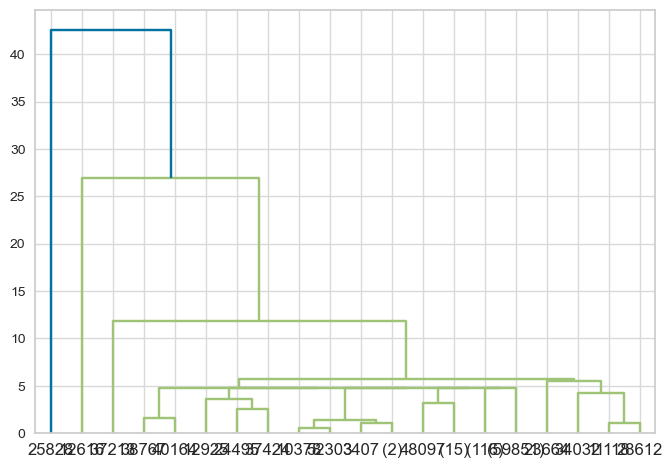

execution time: 22.459 seconds


In [222]:
time_before = time.time()

dendrogram(linkage(X_sample_scaled, "single"), truncate_mode="level", p=8)
plt.show()

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

**Complete Linkage**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster

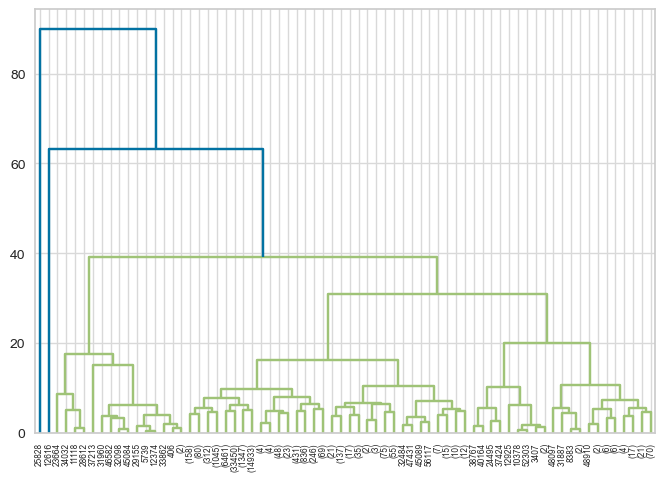

execution time: 131.8322 seconds


In [220]:
time_before = time.time()

dendrogram(linkage(X_sample_scaled, "complete"), truncate_mode="level", p=8)
plt.show()

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

**Average Linkage**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.

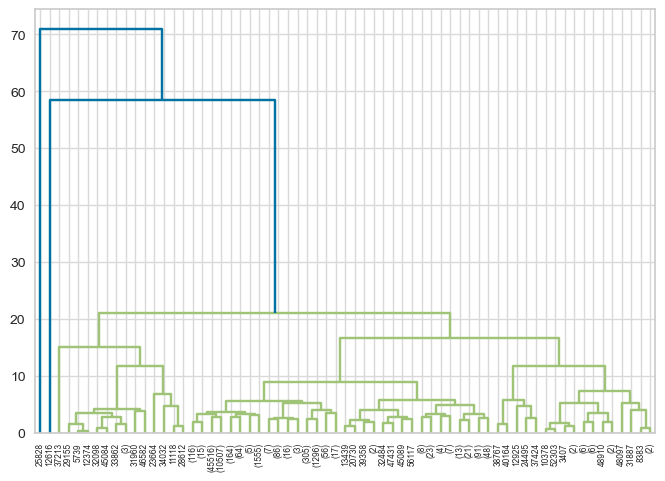

execution time: 152.7785 seconds


In [172]:
time_before = time.time()

dendrogram(linkage(X_sample_scaled, "average"), truncate_mode="level", p=8)
plt.show()

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

**Ward linkage**

The Ward linkage instead of measuring the distance directly, analyzes the variance of clusters.

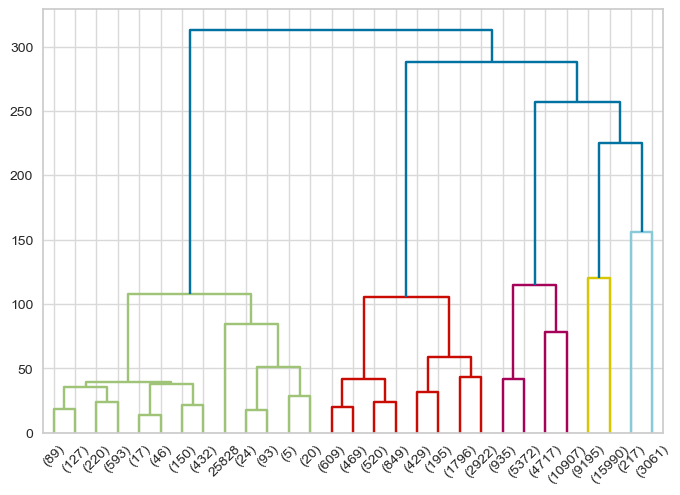

execution time: 133.1458 seconds


In [170]:
time_before = time.time()

dendrogram(linkage(X_sample_scaled, "ward"), truncate_mode="level", p=4)
plt.show()

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

The Ward method performed the best, 5 groups can be clearly distinguished from the above dendrogram so will take 5 as the best number of clusters.

## Training

In [173]:
time_before = time.time()

aggCluster = AgglomerativeClustering(
    n_clusters=5, metric='euclidean', linkage='ward')
aggCluster.fit_predict(X_sample_scaled)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

execution time: 122.5012 seconds


In [174]:
df_rfm_sample['Cluster'] = aggCluster.labels_
df_rfm_sample['Cluster'].unique()

array([1, 3, 2, 4, 0])

## Quick analysis

In [175]:
df_rfm_sample['Cluster'].value_counts()

1    25185
4    21931
2     7789
0     3278
3     1817
Name: Cluster, dtype: int64

In [177]:
df_rfm_sample.groupby("Cluster").mean()

,Recency,Frequency,Monetary,Satisfaction
Cluster,,,,
0,243.0110,1.0040,782.3128,4.3896
1,117.3519,1.0000,126.0134,4.4659
2,279.2881,1.0000,154.1304,1.2792
3,225.8674,2.1095,293.4343,4.1354
4,374.2065,1.0000,115.2093,4.6342


We get very similar results to the KMeans segmentation: 

- Cluster 0: average recency, average frequency, higher than average monetary, above average satisfaction
- Cluster 1: low recency, average frequency, average monetary, high satisfaction
- Cluster 2: average recency, average frequency, average monetary, very low satisfaction
- Cluster 3: average recency, high frequency, above average monetary, average satisfaction
- Cluster 4: high recency, average frequency, average monetary, above average satisfaction

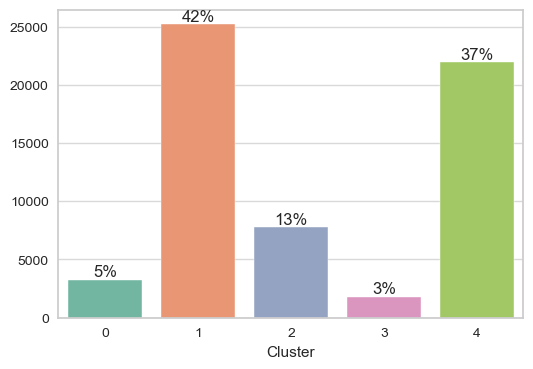

In [224]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm_sample['Cluster'], ax=ax, palette="Set2")

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f}%'.format(
        x/df_rfm_sample.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

From what we see from the average feature values per cluster and clusters distribution, the results are really close to the KMeans, moreover the clusters seem more evenly distributed (probably because of a sample)

**Recency**

<Figure size 1500x500 with 0 Axes>

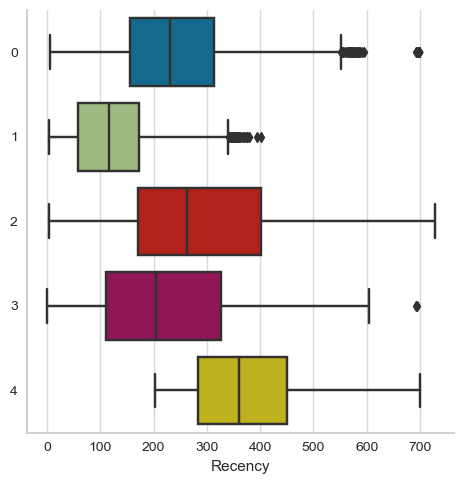

In [333]:
df_rfm_sample['Cluster'] = df_rfm_sample['Cluster'].astype(str)

plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm_sample.sort_values('Cluster'),
            x="Recency", y="Cluster", kind="box")

plt.ylabel(ylabel='')
plt.show()

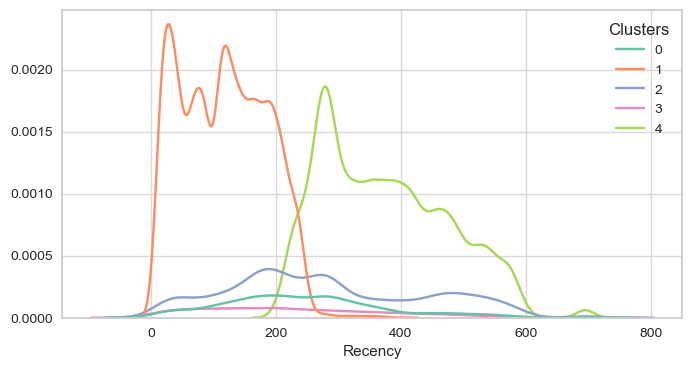

In [334]:
plt.figure(figsize=(8, 4))

g = sns.kdeplot(data=df_rfm_sample.sort_values('Cluster'),
                x="Recency", hue="Cluster", palette="Set2")
g.legend_.set_title('Clusters')
plt.ylabel(ylabel=None)

plt.show()

<u>Cluster 1:</u> low recency

<u>Cluster 4: </u> high recency

Other clusters: average recency

**Frequency**

<Figure size 1500x500 with 0 Axes>

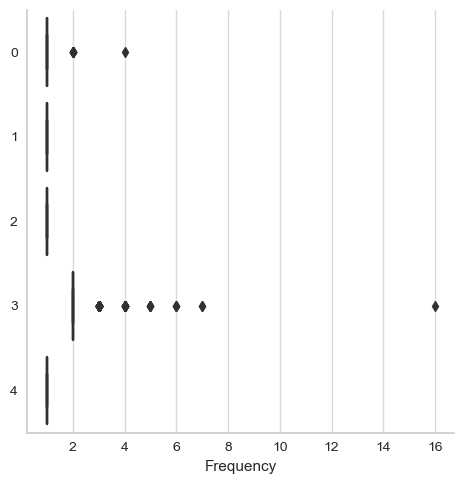

In [335]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm_sample.sort_values('Cluster'),
            x="Frequency", y="Cluster", kind="box")

plt.ylabel(ylabel='')
plt.show()

Cluster 3 stands out as having the highest frequency.

**Monetary**

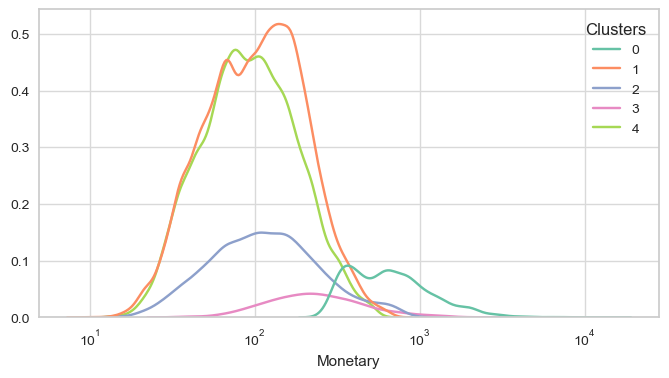

In [336]:
plt.figure(figsize=(8, 4))

g = sns.kdeplot(data=df_rfm_sample.sort_values('Cluster'),
                x="Monetary",
                hue="Cluster",
                palette="Set2",
                log_scale=True,
                warn_singular=False)

g.legend_.set_title('Clusters')
plt.ylabel(ylabel=None)

plt.show()

<u>Cluster 0:</u> highest monetary

<u>Cluster 3:</u> above average monetary

Other clusters have an average monetary value


**Satisfaction**

<Figure size 1500x500 with 0 Axes>

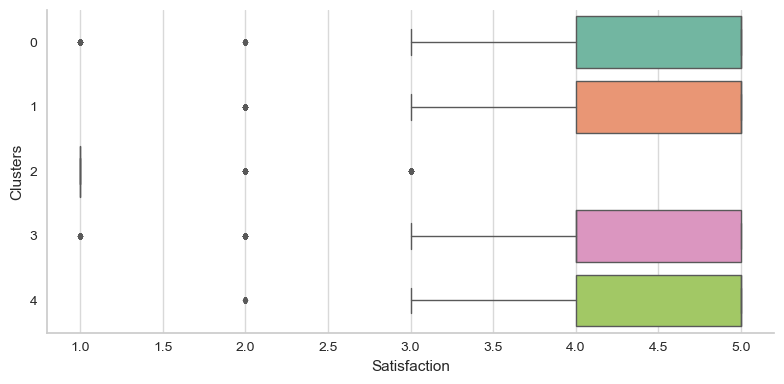

In [337]:
plt.figure(figsize=(15, 5))

sns.catplot(data=df_rfm_sample.sort_values('Cluster'),
            x="Satisfaction",
            y="Cluster",
            kind="box",
            height=4,
            aspect=2,
            linewidth=1,
            fliersize=3,
            palette="Set2")

plt.ylabel(ylabel='Clusters')
plt.show()

Cluster 2 stands out as having the lowest satisfaction score, other clusters are in the average.

**Conclusion**

Agglomerative clusterings defines segments with the same caracteristics as the KMeans but they look more evenly spread than in KMeans (it might be due to the sample quality). The dendrogram is clear and easy to use to select clusters. However, the main drawback is time complexity, the sample of 60000 items was the highest amount that the algorithm could handle in a reasonable amount of time.

# DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. There are two parameters to the algorithm, min_samples and eps. Higher min_samples or lower eps indicate higher density necessary to form a cluster, min_samples primarily controls how tolerant the algorithm is towards noise, the parameter eps controls the local neighborhood of the points.

Start by scaling the data

In [179]:
dbscan_scaler = StandardScaler()
X_dbscan_scaled = dbscan_scaler.fit_transform(df_rfm[rfms_features])

In [180]:
X_dbscan_scaled

array([[-0.83312584, -0.16104597, -0.10585274,  0.68041877],
       [-0.81353754, -0.16104597, -0.60821607, -0.07612273],
       [ 1.94841326, -0.16104597, -0.34969888, -0.83266423],
       ...,
       [ 2.15082573, -0.16104597, -0.23478289,  0.68041877],
       [-0.78089037, -0.16104597, -0.14180779,  0.68041877],
       [ 1.60235323, -0.16104597, -0.41390119,  0.68041877]])

## Choosing the right hyperparameters


The hyperparameters have certain rules for assigning them values :
- **min_samples** : If D represents the number of dimensions / features of a dataset, then min_samples >= D + 1. Typically min_samples >= 2 * D is selected for smaller or noisy datasets.
- **eps** : It's value is usually decided using the k-distance graph that is determined from the KNN model. The value at which the graph changes sharply is selected.

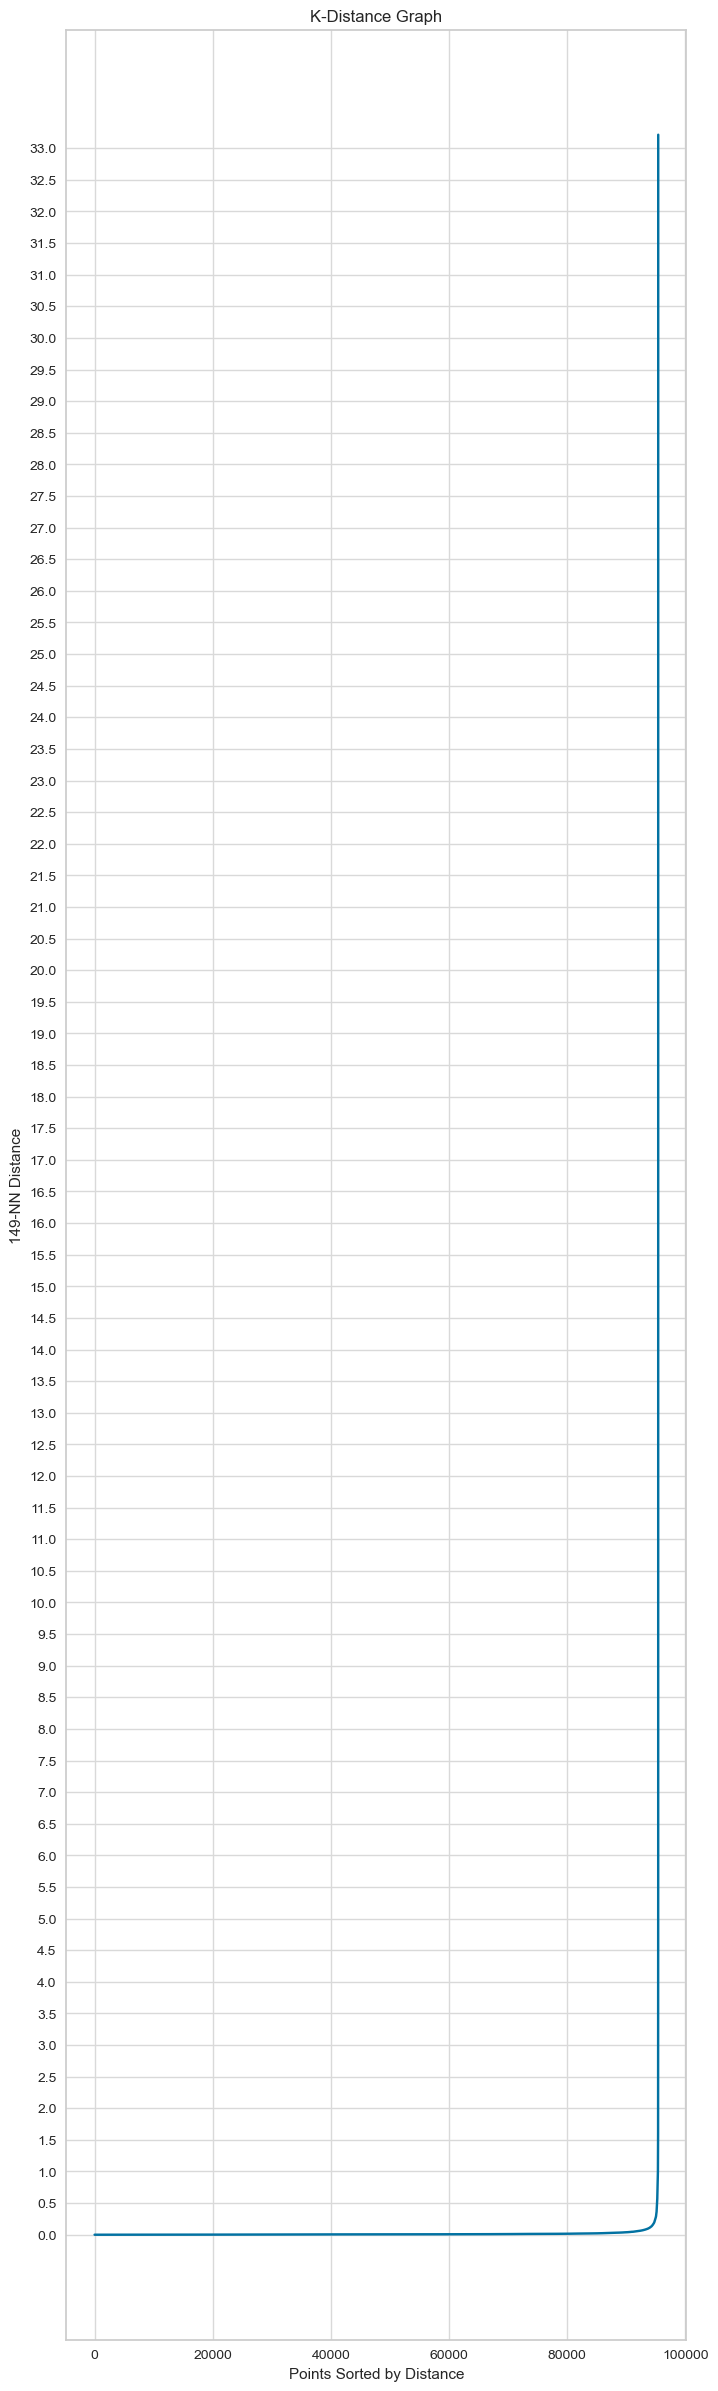

In [190]:
knn = NearestNeighbors(n_neighbors=149)
model = knn.fit(X_dbscan_scaled)
distances, indices = knn.kneighbors(X_dbscan_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(8, 30))
plt.plot(distances)
plt.yticks(np.arange(0, max(distances), .5))
plt.xlabel('Points Sorted by Distance')
plt.ylabel('149-NN Distance')
plt.title('K-Distance Graph')
plt.show()

Different min_samples parameters have been tested, starting from 10 and going to 200, with the 150 min_samples we obtained the most consistent results as to the number of clusters.


From the graph above, eps of 0.2 looks convinient.

## Training

In [350]:
time_before = time.time()

dbscan = DBSCAN(eps=0.2, min_samples=150)
dbscan_labels = dbscan.fit_predict(X_dbscan_scaled)

exec_time = round((time.time() - time_before), 4)
print(f'execution time: {exec_time} seconds')

execution time: 3.9987 seconds


In [351]:
df_rfm['DBSCAN_cluster'] = dbscan_labels
df_rfm['DBSCAN_cluster'].sort_values().unique()

array([-1,  0,  1,  2,  3,  4])

In [352]:
df_rfm['DBSCAN_cluster'].value_counts()

 0    49957
 1    16601
-1    13376
 3     8203
 2     6267
 4     1015
Name: DBSCAN_cluster, dtype: int64

In [353]:
df_rfm[rfms_features + ["DBSCAN_cluster"]].groupby("DBSCAN_cluster").mean()

,Recency,Frequency,Monetary,Satisfaction
DBSCAN_cluster,,,,
-1,275.0114,1.2427,486.0868,3.4430
0,236.4099,1.0000,118.9764,5.0000
1,242.1257,1.0000,107.1764,4.0000
2,243.2151,1.0000,96.9281,3.0000
3,232.0496,1.0000,113.7070,1.0000
4,208.9360,1.0000,80.0540,2.0000


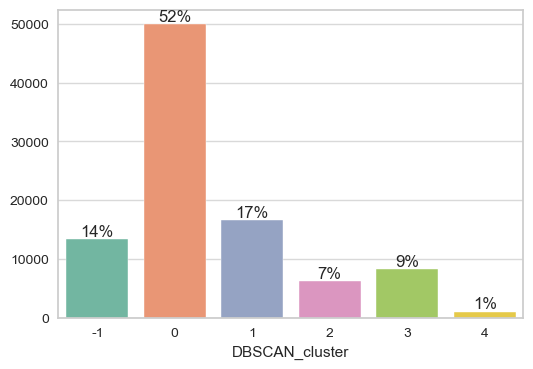

In [354]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df_rfm['DBSCAN_cluster'], ax=ax, palette="Set2")

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f}%'.format(x/df_rfm.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

It looks like the clusters were obtained depending on the satisfaction feature, which is not representative of the data, we also get 14% of noise.

**Conclusion**

The DBSCAN algorithm gave the least conclusive results in terms of cluster consistency. Choosing the right hyperparameters is not obvious, the KNN method helped but is not straightforward to use. However, it is the most high-performing algorithm among the three that have been tested, but it is probably not adapted for our use case.


# Results

To sum up, here is an overview on the 3 clustering algorithms:

 1. The **KMeans** performed really well with the given dataset, the clusters obtained were consistent from the domain point of view and are representative of the data. It is less high-performing compared to DBSCAN but the execution time is reasonable (60 seconds including the calculation of the silhouette score which is time consuming). The main drawback might be a certain complexity of the process because the number of clusters have to be chosen beforehand and the procedure takes time and involves domain knowledge to make a decision.<br/>
 
 
 2. The **Agglomerative Clustering** gave excellent results in terms of obtained clusters which are similar to those defined by KMeans. The process of choosing the right number of clusters is easier thanks to the dendrogram that gives a very clear representation of the clusters. However, the main drawback is time complexity, and only a sample of data was used. Therefore it is difficult to judge the quality of the clustering given this fact.<br/>
 
 
 3. The **DBSCAN** gave the least conclusive results despite being the most high-performing. The choice of hyperparameters is not obvious and they might have to be reconfigured for the dataset updates. The clusters were not consistent and a lot of noise has been detected.<br/>
 
 
 
 Given the points above, the recommandation is to use the KMeans which suits best the dataset and the use case of the project.